# Time-Series Analysis of Criteria Pollutant Levels 
## Highlighting Lockdown Periods

In [1]:
# required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import math
import statistics

import datetime as dt
import matplotlib.dates

from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import *

from collections import defaultdict

print('done')

done


# Loading and processing data

In [2]:
# get list of stations
stations_file = '~/Documents/GitHub/HMEI-2021/stations.csv'

df_stations = pd.read_csv(stations_file)
df_stations.head()

Full       Spaced     Key        Key2        Key3  \
0       Alipur, Delhi - DPCC       Alipur  Alipur      Alipur      Alipur   
1  Anand Vihar, Delhi - DPCC  Anand Vihar   Anand  AnandVihar  AnandVihar   
2  Ashok Vihar, Delhi - DPCC  Ashok Vihar   Ashok  AshokVihar  AshokVihar   
3     Aya Nagar, Delhi - IMD    Aya Nagar     Aya    AyaNagar    AyaNagar   
4       Bawana, Delhi - DPCC       Bawana  Bawana      Bawana      Bawana   

         Key4  
0      Alipur  
1  AnandVihar  
2  AshokVihar  
3    AyaNagar  
4      Bawana

In [3]:
# refer to stations by preset keys
stations20_21 = [s for s in df_stations['Key3'] if type(s) == str]
stations15_19 = [s for s in df_stations['Key4'] if type(s) == str]

In [4]:
print(len(stations20_21))
print(len(stations15_19))

39
33


## Load hourly data

In [5]:
station_data = {} # dictionary to store each station's data

for station in stations20_21:
    file_str = '~/Documents/GitHub/HMEI-2021/station_data/data_' + station + '.csv'
    df_station = pd.read_csv(file_str)
    
    # set datetime as index
    df_station.index = pd.to_datetime(df_station['From Date'])
    df_station = df_station.drop(columns=['From Date'])

    end_date = pd.to_datetime('2021-05-31 23:00:00')
    df_station = df_station.loc[:end_date]
    
    station_data[station] = {'hourly': df_station}

In [6]:
for station in station_data:
    print(station_data[station]['hourly'].shape)

(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(12408, 2)
(56232, 4)
(12408, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)


## Add dataframes of various timesteps to each station's dictionary

In [7]:
# return mean of array with the condition that at least 1 non-NaN value must be present
# if condition is not satisfied, return NaN
def at_least_one(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 1:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [8]:
# return mean of array with the condition that at least 2 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_two(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 2:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [9]:
# return mean of array with the condition that at least 8 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_eight(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 8:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [10]:
# get the MDA8 ozone value for a 24-hour period
def MDA8_Ozone(array):
    max_avg = None
    i = 0
    while i + 8 <= len(array):
        elems = []
        for j in range(i, i+8):
            if not math.isnan(array[j]):
                elems.append(array[j])
        # must include at least 6 hourly values to get an average
        if len(elems) >= 6:
            avg = sum(elems) / len(elems)
            if (not max_avg) or (avg > max_avg):
                max_avg = avg
        i += 1
    if not max_avg:
        return math.nan
    else:
        return max_avg

In [11]:
for station in station_data:
    try:
        hourly = station_data[station]['hourly']
        diurnal = hourly.loc['2015-01-01 6:00:00':, hourly.columns != 'Ozone'].resample('12H', origin='2015-01-01 6:00:00').apply(at_least_one)
        daily = diurnal.resample('24H', origin='2015-01-01 06:00:00').apply(at_least_two)
        
        if 'Ozone' in hourly.columns:
            mda8_ozone = hourly.loc['2015-01-01 6:00:00':, 'Ozone'].resample('24H', origin='2015-01-01 6:00:00').apply(MDA8_Ozone)
            daily['Ozone'] = mda8_ozone
        
        monthly = daily.resample('M').apply(at_least_eight)
        monthly = monthly.rename_axis(index='To Date')
        
        # add to dictionary
        station_data[station]['diurnal'] = diurnal 
        station_data[station]['daily'] = daily
        station_data[station]['monthly'] = monthly
        
    except Exception as e:
        print(e, station)

In [12]:
# get seasonal averages
for station in station_data:
    monthly = station_data[station]['monthly']

    seasonal = pd.DataFrame(index=['DJF2015', 'MAM2015', 'JJA2015', 'SON2015', 
                                   'DJF2016', 'MAM2016', 'JJA2016', 'SON2016',
                                   'DJF2017', 'MAM2017', 'JJA2017', 'SON2017',
                                   'DJF2018', 'MAM2018', 'JJA2018', 'SON2018',
                                   'DJF2019', 'MAM2019', 'JJA2019', 'SON2019',
                                   'DJF2020', 'MAM2020', 'JJA2020', 'SON2020',
                                   'DJF2021', 'MAM2021'],
                                    columns=monthly.columns)

    DJF_2015 = monthly.loc['2015-01':'2015-02']
    for col in DJF_2015.columns:
        seasonal.loc['DJF2015', col] = at_least_one(DJF_2015[col])

    for year in range(2016, 2022):
        date_start = str(year - 1) + '-12'
        date_end = str(year) + '-02'
        row = 'DJF' + str(year)
        DJF = monthly.loc[date_start:date_end]
        for col in DJF.columns:
            seasonal.loc[row, col] = at_least_one(DJF[col])

    for year in range(2015, 2022):
        date_start = str(year) + '-03'
        date_end = str(year) + '-05'
        row = 'MAM' + str(year)
        MAM = monthly.loc[date_start:date_end]
        for col in MAM.columns:
            seasonal.loc[row, col] = at_least_one(MAM[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-06'
        date_end = str(year) + '-08'
        row = 'JJA' + str(year)
        JJA = monthly.loc[date_start:date_end]
        for col in JJA.columns:
            seasonal.loc[row, col] = at_least_one(JJA[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-09'
        date_end = str(year) + '-11'
        row = 'SON' + str(year)
        SON = monthly.loc[date_start:date_end]
        for col in SON.columns:
            seasonal.loc[row, col] = at_least_one(SON[col])
            
    station_data[station]['seasonal'] = seasonal

In [13]:
# get yearly averages
for station in station_data:
    seasonal = station_data[station]['seasonal']
    yearly = pd.DataFrame(index=[x for x in range(2015, 2021)], columns=seasonal.columns)

    for year in range(2015, 2021):
        start_date = 'DJF' + str(year)
        end_date = 'SON' + str(year)
        YA = seasonal.loc[start_date:end_date]
        for col in seasonal:
            yearly.loc[year, col] = at_least_one(YA[col])
    
    station_data[station]['yearly'] = yearly

## Average data across all stations for each pollutant

In [15]:
def calcSE(orig_sample):
    sample = [x for x in orig_sample if not math.isnan(x)]
    if len(sample) < 2:
        return 0
    sigma = statistics.stdev(sample)
    se = sigma / (math.sqrt(len(sample)))
    return se

In [16]:
# AVERAGE VALUES ACROSS ALL STATIONS FOR EACH SPECIES
# STORE DATAFRAMES IN DICTIONARY 'holistic'

holistic = {}
time_levels = ['hourly', 'daily', 'monthly', 'seasonal', 'yearly']

for time_level in time_levels:
    # use arbitrary station to get the list of datetime indices
    ts_index = station_data['Alipur'][time_level].index

    # initialize df's for summarizing species data across stations
    pm25 = pd.DataFrame(index=ts_index)
    pm10 = pd.DataFrame(index=ts_index)
    no2 = pd.DataFrame(index=ts_index)
    so2 = pd.DataFrame(index=ts_index)
    ozone = pd.DataFrame(index=ts_index)

    for station in station_data:
        df = station_data[station][time_level]
        cols = df.columns
        if 'PM2.5' in cols:
            pm25[station] = df['PM2.5']
        if 'PM10' in cols:
            pm10[station] = df['PM10']
        if 'NO2' in cols:
            no2[station] = df['NO2']
        if 'SO2' in cols:
            so2[station] = df['SO2']
        if 'Ozone' in cols:
            ozone[station] = df['Ozone']

    holistic[time_level] = {}
    holistic[time_level]['PM2.5'] = pd.DataFrame(index=ts_index, columns=['mean', 'maximum', 'minimum'])
    holistic[time_level]['PM10'] = pd.DataFrame(index=ts_index, columns=['mean', 'maximum', 'minimum'])
    holistic[time_level]['NO2'] = pd.DataFrame(index=ts_index, columns=['mean', 'maximum', 'minimum'])
    holistic[time_level]['SO2'] = pd.DataFrame(index=ts_index, columns=['mean', 'maximum', 'minimum'])
    holistic[time_level]['Ozone'] = pd.DataFrame(index=ts_index, columns=['mean', 'maximum', 'minimum'])
    
    holistic[time_level]['PM2.5']['mean'] = pm25.mean(axis=1, skipna=True)
    holistic[time_level]['PM10']['mean'] = pm10.mean(axis=1, skipna=True)
    holistic[time_level]['NO2']['mean'] = no2.mean(axis=1, skipna=True)
    holistic[time_level]['SO2']['mean'] = so2.mean(axis=1, skipna=True)
    holistic[time_level]['Ozone']['mean'] = ozone.mean(axis=1, skipna=True)
    
    se_pm25 = pm25.apply(calcSE, axis=1)
    se_pm10 = pm10.apply(calcSE, axis=1)
    se_no2 = no2.apply(calcSE, axis=1)
    se_so2 = so2.apply(calcSE, axis=1)
    se_ozone = ozone.apply(calcSE, axis=1)
    
    holistic[time_level]['PM2.5']['lowermean'] = holistic[time_level]['PM2.5']['mean'] - se_pm25
    holistic[time_level]['PM10']['lowermean'] = holistic[time_level]['PM10']['mean'] - se_pm10
    holistic[time_level]['NO2']['lowermean'] = holistic[time_level]['NO2']['mean'] - se_no2
    holistic[time_level]['SO2']['lowermean'] = holistic[time_level]['SO2']['mean'] - se_so2
    holistic[time_level]['Ozone']['lowermean'] = holistic[time_level]['Ozone']['mean'] - se_ozone
    
    holistic[time_level]['PM2.5']['uppermean'] = holistic[time_level]['PM2.5']['mean'] + se_pm25
    holistic[time_level]['PM10']['uppermean'] = holistic[time_level]['PM10']['mean'] + se_pm10
    holistic[time_level]['NO2']['uppermean'] = holistic[time_level]['NO2']['mean'] + se_no2
    holistic[time_level]['SO2']['uppermean'] = holistic[time_level]['SO2']['mean'] + se_so2
    holistic[time_level]['Ozone']['uppermean'] = holistic[time_level]['Ozone']['mean'] + se_ozone
    
    holistic[time_level]['PM2.5']['minimum'] = pm25.min(axis=1, skipna=True)
    holistic[time_level]['PM10']['minimum'] = pm10.min(axis=1, skipna=True)
    holistic[time_level]['NO2']['minimum'] = no2.min(axis=1, skipna=True)
    holistic[time_level]['SO2']['minimum'] = so2.min(axis=1, skipna=True)
    holistic[time_level]['Ozone']['minimum'] = ozone.min(axis=1, skipna=True)
    
    holistic[time_level]['PM2.5']['maximum'] = pm25.max(axis=1, skipna=True)
    holistic[time_level]['PM10']['maximum'] = pm10.max(axis=1, skipna=True)
    holistic[time_level]['NO2']['maximum'] = no2.max(axis=1, skipna=True) 
    holistic[time_level]['SO2']['maximum'] = so2.max(axis=1, skipna=True)
    holistic[time_level]['Ozone']['maximum'] = ozone.max(axis=1, skipna=True)

In [17]:
five_year_means = {}
for col in list(holistic['yearly'].keys()):
    five_year_means[col] = holistic['yearly'][col]['mean'].mean()

# Analysis and visualization

## Plot hourly and monthly means by station, from Jan 2020 - May 2021

In [14]:
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

def plotStationData(key):
    
    df_hourly = station_data[key]['hourly']['2020-01-01':'2021-05-31']
    df_monthly = station_data[key]['monthly']['2020-01-01':'2021-05-31']

    cols = df_hourly.columns
    
    # first_date = df_hourly.index[0]
    # last_date = df_hourly.index[-1]
    
    fig, axs = plt.subplots(len(cols), figsize=(24,20))

    for col, ax in zip(cols, axs):
          
        dat = df_hourly[col] # df with hourly means
        y1  = dat.loc[:'2020-03-23']
        ld1 = dat.loc['2020-03-24':'2020-05-31']
        y2  = dat.loc['2020-06-01':'2021-04-18']
        ld2 = dat.loc['2021-04-19':'2021-05-31']
        mm  = df_monthly[col] # df with monthly means

        # Plotting hourly mean values in the backdrop
        ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
                label='Hourly mean')
        ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
                label='Hourly mean during lockdown')
        ax.plot(y2, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5')
        ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5')
        
        # Overlaying hourly mean values with monthly means
        ax.plot(mm, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
        ax.plot(mm, marker='o', markersize=15, linewidth=0,
                markerfacecolor='yellow',
                markeredgecolor='black',
                markeredgewidth=2, label='Monthly mean') # monthly means as yellow dot
        
        ax.set_ylabel(pol_labels_dict[col] + ' ($µg/m^3$)', fontsize=12)
        # ax.set_title(col, fontsize=18)
        # ax.set_xlim(first_date, last_date)
        if col == 'PM2.5':
            ax.legend(bbox_to_anchor=(1, 1.4), loc='upper right')
        
    plt.suptitle('Hourly and Monthly Means of Pollutant Levels\n\n' + 'Station: ' + key,
                 fontsize=22)
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.2)
    fig_title = 'Timeseries_' + key + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready:', fig_title)
    plt.show()    

figure ready: Timeseries_CRRI.tiff


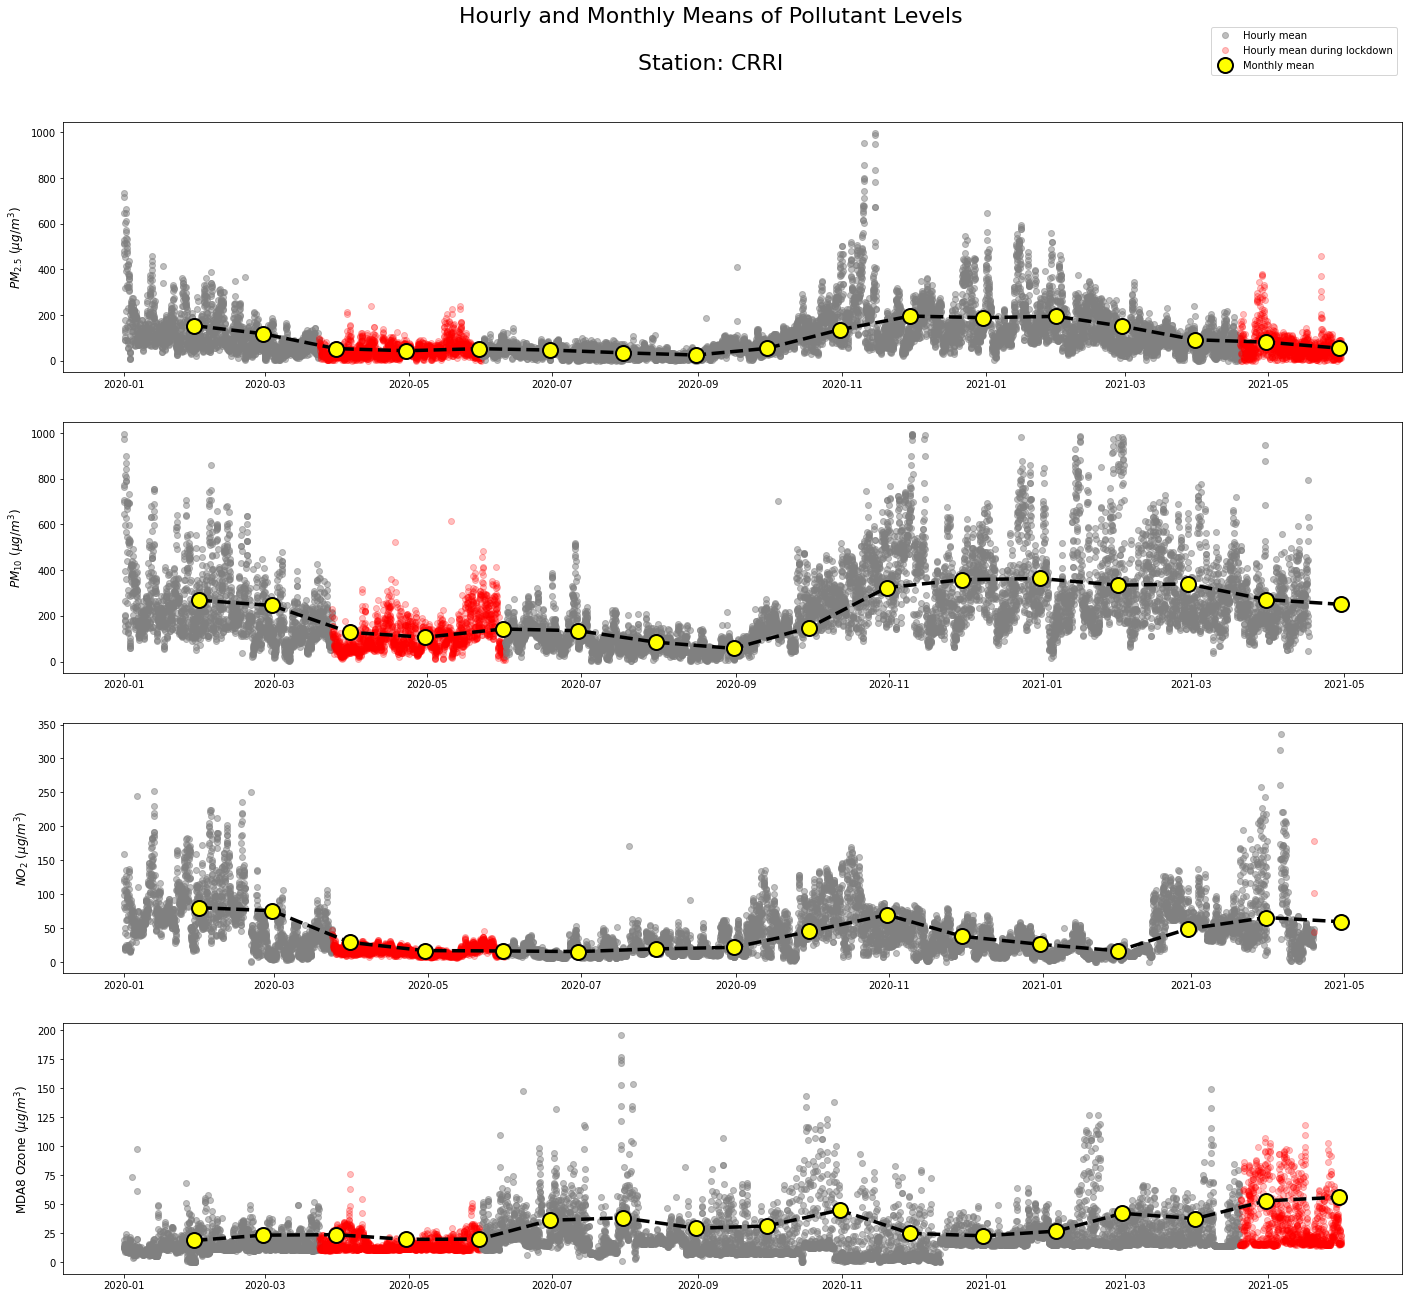

In [15]:
plotStationData('CRRI')

## Make boxplots using dates from Singh et al

In [438]:
def makeBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = [[], []]
    for station in df_daily.columns:
        avgs[0].append(at_least_one(df_daily[station]['2020-03-22':'2020-03-31']))
        avgs[1].append(at_least_one(df_daily[station]['2020-03-01':'2020-03-31']))

    avgs[0] = [x for x in avgs[0] if math.isnan(x) == False]
    avgs[1] = [x for x in avgs[1] if math.isnan(x) == False]

    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.boxplot(avgs)
    ax.set_title(pollutant + ' Over Delhi\nPeak Lockdown 2020 vs. March 2020')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([1, 2], ['2020 March 22-31', '2020 March'])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

## Boxplots of weekly averages during lockdown periods in 2020 and 2021, highlighting the shared lockdown period

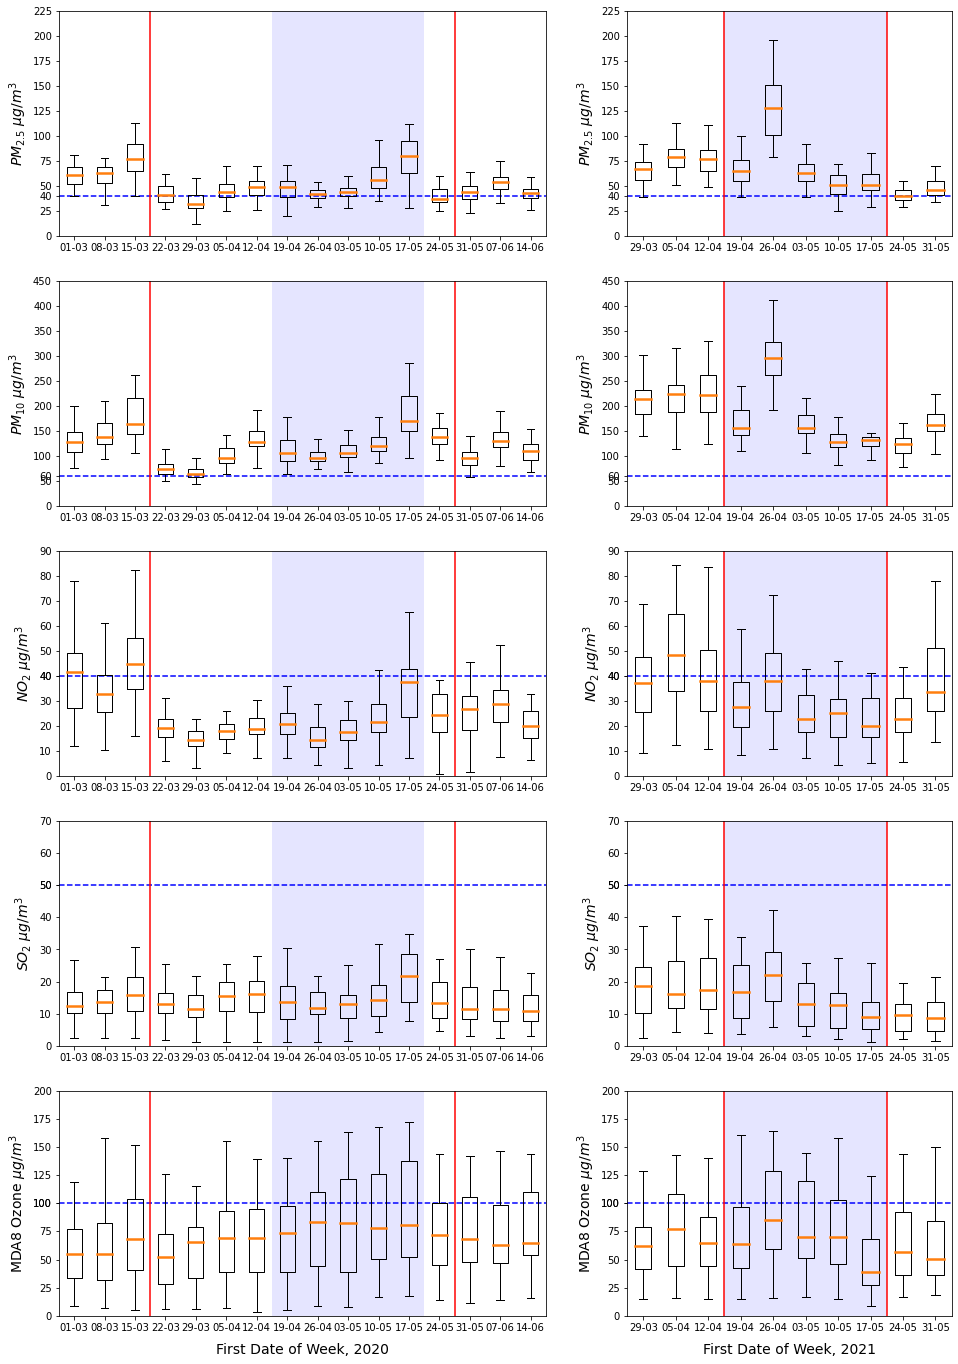

In [19]:
# 2020
# prelockdown: march 1st - march 23rd
# lockdown: march 24th  - april 18th
# shared lockdown: april 19th - may 24th
# lockdown: may 25th - may 31st
# postlockdown: june 1st - june 18st

# 2021
# prelockdown: april 1st - april 18th
# shared lockdown: april 19th - may 24th
# postlockdown: may 25th - june 18th

pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
fig, axs = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize=(16, 24))

for i in range(len(pollutants)):
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2020-03-01':'2020-06-18']
            weekly_avgs = daily_avgs.resample('7D').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)

    props = {'linewidth': 2.5}
    axs[i][0].boxplot(avgs_list, showfliers=False, medianprops=props)
    '''if pollutants[i] == 'PM2.5':
        axs[i][0].set_title('Weekly Averages of Pollution Levels Over Delhi\nBefore and During 2020 Lockdown', 
                         fontsize=14, pad=15)'''
    
    top2020 = axs[i][0].get_ylim()[1]
    if top2020 < standards[pollutants[i]]:
        top2020 = standards[pollutants[i]] + 20

    axs[i][0].set_ylabel(pol_labels[i] + ' $µg/m^3$', fontsize=14)
    axs[i][0].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i][0].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    axs[i][0].hlines(y=standards[pollutants[i]], xmin=0.5, 
                     xmax=list(axs[i][0].get_xticks())[-1] + 0.5, color='b', linestyles='dashed',
                     linewidth=1.5, zorder=0, label='CPCB Standard')
    
    ######
    # 2021
    ######
    
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2021-03-29':'2021-06-18']
            weekly_avgs = daily_avgs.resample('7D').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)

    props = {'linewidth': 2.5}
    axs[i][1].boxplot(avgs_list, showfliers=False, medianprops=props)
    '''if pollutants[i] == 'PM2.5':
        axs[i][0].set_title('Weekly Averages of Pollution Levels Over Delhi\nBefore and During 2020 Lockdown', 
                         fontsize=14, pad=15)'''
    
    top2021 = axs[i][1].get_ylim()[1]
    if top2021 < standards[pollutants[i]]:
        top2021 = standards[pollutants[i]] + 20

    axs[i][1].set_ylabel(pol_labels[i] + ' $µg/m^3$', fontsize=14)
    axs[i][1].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i][1].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    axs[i][1].hlines(y=standards[pollutants[i]], xmin=0.5, 
                     xmax=list(axs[i][1].get_xticks())[-1] + 0.5, color='b', linestyles='dashed',
                     linewidth=1.5, zorder=0, label='CPCB Standard')

    '''if pollutants[i] == 'PM2.5':
        axs[i][0].legend(bbox_to_anchor=(0.89, 1.25), loc='upper center')'''

    if top2020 > top2021:
        top = top2020
    else:
        top = top2021

    axs[i][0].set_ylim(0, top)
    axs[i][0].set_yticks(list(axs[i][0].get_yticks()) + [standards[pollutants[i]]])
    axs[i][0].vlines(x=3.5,  ymin=0, ymax=list(axs[i][0].get_yticks())[-2], color='r', linestyles='solid')
    axs[i][0].vlines(x=13.5, ymin=0, ymax=list(axs[i][0].get_yticks())[-2], color='r', linestyles='solid')
    axs[i][0].axvspan(7.5, 12.5, facecolor='blue', alpha=0.10, zorder=0)
    '''axs[i][0].hlines(y=five_year_means[pollutants[i]], xmin=axs[i][0].get_xlim()[0], xmax=axs[i][0].get_xlim()[1], 
                     color='purple', linestyles='dashed', linewidth=1.5, 
                     label='2015-2019 Average')'''

    axs[i][1].set_ylim(0, top)
    axs[i][1].set_yticks(list(axs[i][1].get_yticks()) + [standards[pollutants[i]]])
    axs[i][1].vlines(x=3.5, ymin=0, ymax=list(axs[i][1].get_yticks())[-2], color='r', linestyles='solid')
    axs[i][1].vlines(x=8.5, ymin=0, ymax=list(axs[i][1].get_yticks())[-2], color='r', linestyles='solid')
    axs[i][1].axvspan(3.5, 8.5, facecolor='blue', alpha=0.10, zorder=0)
    '''axs[i][1].hlines(y=five_year_means[pollutants[i]], xmin=axs[i][1].get_xlim()[0], xmax=axs[i][1].get_xlim()[1], 
                     color='purple', linestyles='dashed', linewidth=1.5, 
                     label='2015-2019 Average')'''
    
    if pollutants[i] == 'Ozone':
        axs[i][0].set_xlabel('First Date of Week, 2020', fontsize=14, labelpad=10)
        axs[i][1].set_xlabel('First Date of Week, 2021', fontsize=14, labelpad=10)
    
fig_title = '2020_2021_Shared_Lockdown_Box_Plot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

# plt.xlabel('First Date of Week', fontsize=14, labelpad=10)
plt.show()

## Boxplots of weekly averages before, during, and after 2020 lockdown 

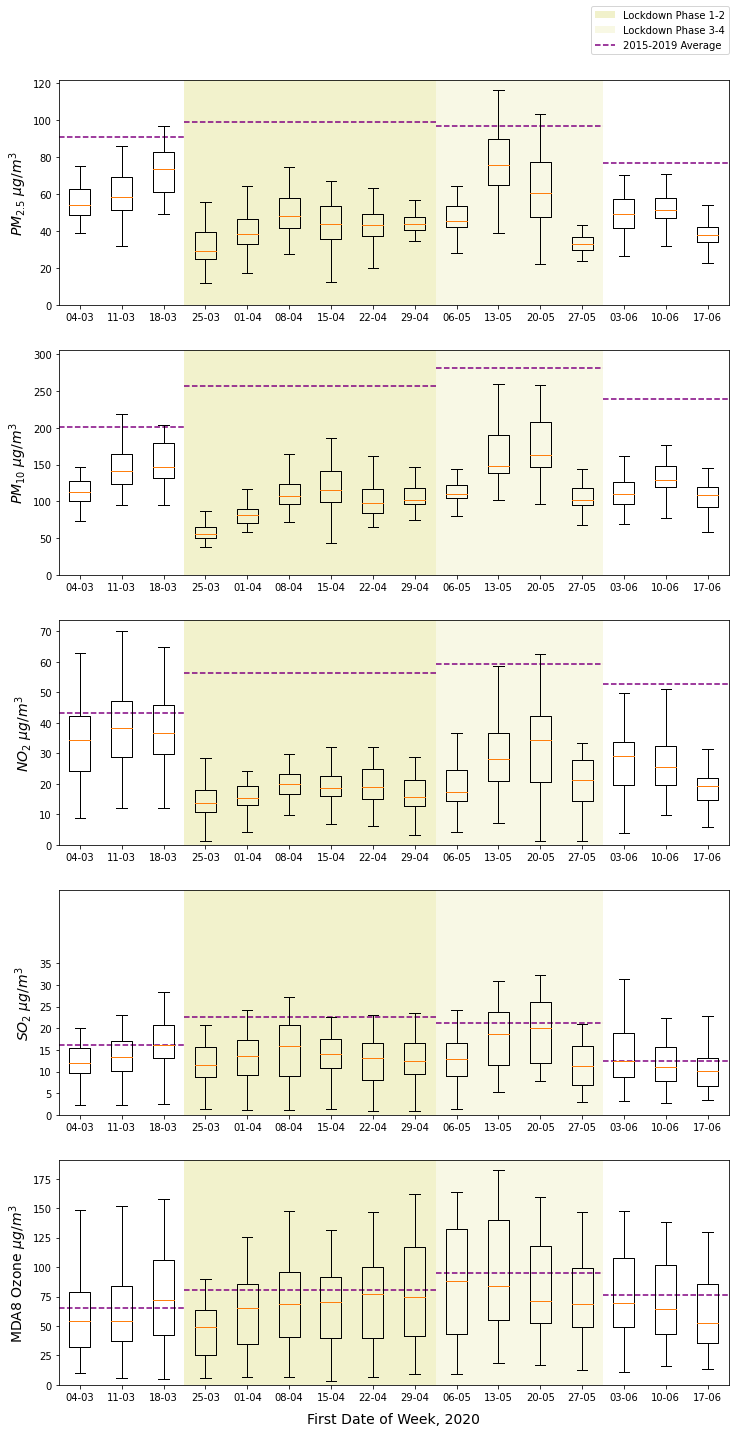

In [100]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
fig, axs = plt.subplots(5, figsize=(12, 24))

for i in range(5):
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2020-03-04':'2020-06-23']
            weekly_avgs = daily_avgs.resample('7D').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])
    
    prev_avgs = defaultdict(list)
    for year in range(2015, 2020):
        s1 = str(year) + '-03-04'
        e1 = str(year) + '-03-24'
        prev_avgs['pre-ld'].append(holistic['daily'][pollutants[i]]['mean'].loc[s1:e1])
        s2 = str(year) + '-03-25'
        e2 = str(year) + '-05-05'
        prev_avgs['ld1'].append(holistic['daily'][pollutants[i]]['mean'].loc[s2:e2])
        s3 = str(year) + '-05-06'
        e3 = str(year) + '-06-02'
        prev_avgs['ld2'].append(holistic['daily'][pollutants[i]]['mean'].loc[s3:e3])
        s4 = str(year) + '-06-03'
        e4 = str(year) + '-06-23'
        prev_avgs['post-ld'].append(holistic['daily'][pollutants[i]]['mean'].loc[s4:e4])
    
    five_year_avgs = defaultdict(list)
    for year_vals in prev_avgs['pre-ld']:
        five_year_avgs['pre-ld'].append(year_vals.mean())
    
    for year_vals in prev_avgs['ld1']:
        five_year_avgs['ld1'].append(year_vals.mean())
    
    for year_vals in prev_avgs['ld2']:
        five_year_avgs['ld2'].append(year_vals.mean())
    
    for year_vals in prev_avgs['post-ld']:
        five_year_avgs['post-ld'].append(year_vals.mean())
        
    preld_lim = at_least_one(five_year_avgs['pre-ld'])
    ld1_lim = at_least_one(five_year_avgs['ld1'])
    ld2_lim = at_least_one(five_year_avgs['ld2'])
    postld_lim = at_least_one(five_year_avgs['post-ld'])
    
    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)

    axs[i].boxplot(avgs_list, showfliers=False)
    
    gaps = axs[i].get_yticks()
    gap = (gaps[1] - gaps[0]) // 2

    top = max([axs[i].get_ylim()[1], standards[pollutants[i]] + gap, preld_lim + gap, \
               ld1_lim + gap, ld2_lim + gap, postld_lim + gap])
    
    '''axs[i].hlines(y=standards[pollutants[i]], xmin=0.5, xmax=axs[i].get_xticks()[-1]+0.5, 
                  color='blue', linestyles='dashed', label='CPCB Standard', linewidth=1.5, alpha=0.5)'''
    '''axs[i].hlines(y=five_year_means[pollutants[i]], xmin=axs[i].get_xlim()[0], xmax=axs[i].get_xlim()[1], 
                  color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5)'''
                                    
    axs[i].hlines(y=at_least_one(five_year_avgs['pre-ld']), xmin=0.5, xmax=3.5, 
                  color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5)
    axs[i].hlines(y=at_least_one(five_year_avgs['ld1']), xmin=3.5, xmax=9.5, 
                  color='purple', linestyles='dashed', linewidth=1.5)
    axs[i].hlines(y=at_least_one(five_year_avgs['ld2']), xmin=9.5, xmax=13.5, 
                  color='purple', linestyles='dashed', linewidth=1.5)
    axs[i].hlines(y=at_least_one(five_year_avgs['post-ld']), xmin=13.5, xmax=16.5, 
                  color='purple', linestyles='dashed', linewidth=1.5)
                                    
    axs[i].set_yticks(list(axs[i].get_yticks()))
    axs[i].set_ylabel(pol_labels[i] + ' $µg/m^3$', fontsize=14)
    axs[i].set_ylim(0, top)
    
    axs[i].axvspan(3.5,  9.5, facecolor='y', alpha=0.20, label='Lockdown Phase 1-2')
    axs[i].axvspan(9.5, 13.5, facecolor='y', alpha=0.10, label='Lockdown Phase 3-4')
    
    axs[i].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    '''axs[i].text(x=axs[i].get_xticks()[-1]+0.7, y=five_year_means[pollutants[i]], 
                s=str(round(five_year_means[pollutants[i]], 2)), color='purple')
    axs[i].text(x=axs[i].get_xticks()[-1]+0.7, y=standards[pollutants[i]], 
                s=str(standards[pollutants[i]]), color='blue')'''
    
    # bbox_to_anchor=(0.89, 1.25) 
    if pollutants[i] == 'PM2.5':
        axs[i].legend(bbox_to_anchor=(1.008, 1.35), loc='upper right')

fig_title = '2020_Lockdown_Weekly_Avg_Box_Plot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.xlabel('First Date of Week, 2020', fontsize=14, labelpad=10)
plt.show()

## Total averages before, during, and after 2020 lockdown

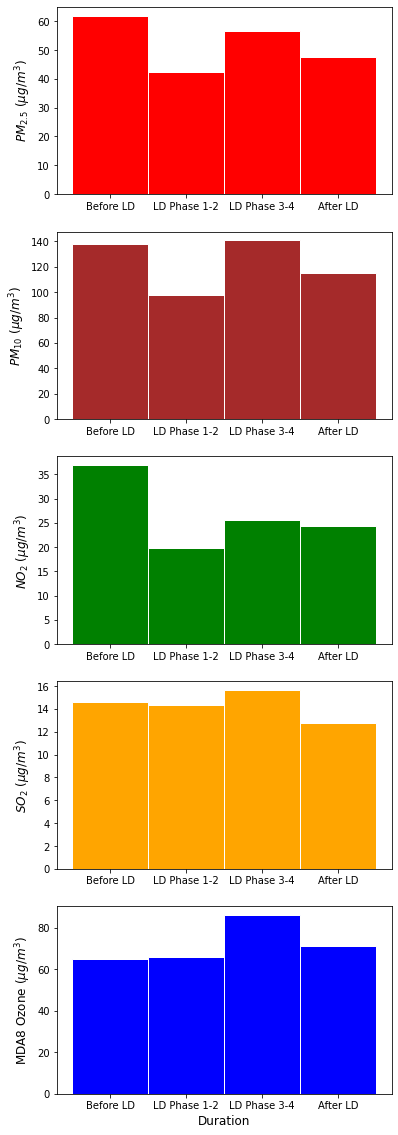

In [38]:
colors = ['red', 'brown', 'green', 'orange', 'blue']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

avgs = defaultdict(list)
for pollutant in holistic['daily'].keys():
    dat = holistic['daily'][pollutant]['mean'].loc['2020-03-04':'2020-06-23']
    avgs[pollutant].append(dat.loc['2020-03-04':'2020-03-24'].mean())
    avgs[pollutant].append(dat.loc['2020-03-25':'2020-05-03'].mean())
    avgs[pollutant].append(dat.loc['2020-05-04':'2020-05-31'].mean())
    avgs[pollutant].append(dat.loc['2020-06-01':'2020-06-23'].mean())

fig, axs = plt.subplots(5, 1, figsize=(6, 20))

for pollutant, ax, color in zip(list(avgs.keys()), axs, colors):
    ax.bar(x=list(range(4)), height=avgs[pollutant], width=1, color=color, edgecolor='white')
    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(['Before LD', 'LD Phase 1-2', 'LD Phase 3-4', 'After LD'])
    ax.set_ylabel(pol_labels_dict[pollutant] + ' ($µg/m^3$)', fontsize=12)
    if pollutant == 'Ozone':
        ax.set_xlabel('Duration', fontsize=12)
    
fig_title = 'Avgs_During_LD_Dates_2020.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Boxplots of weekly averages before, during, and after 2021 lockdown

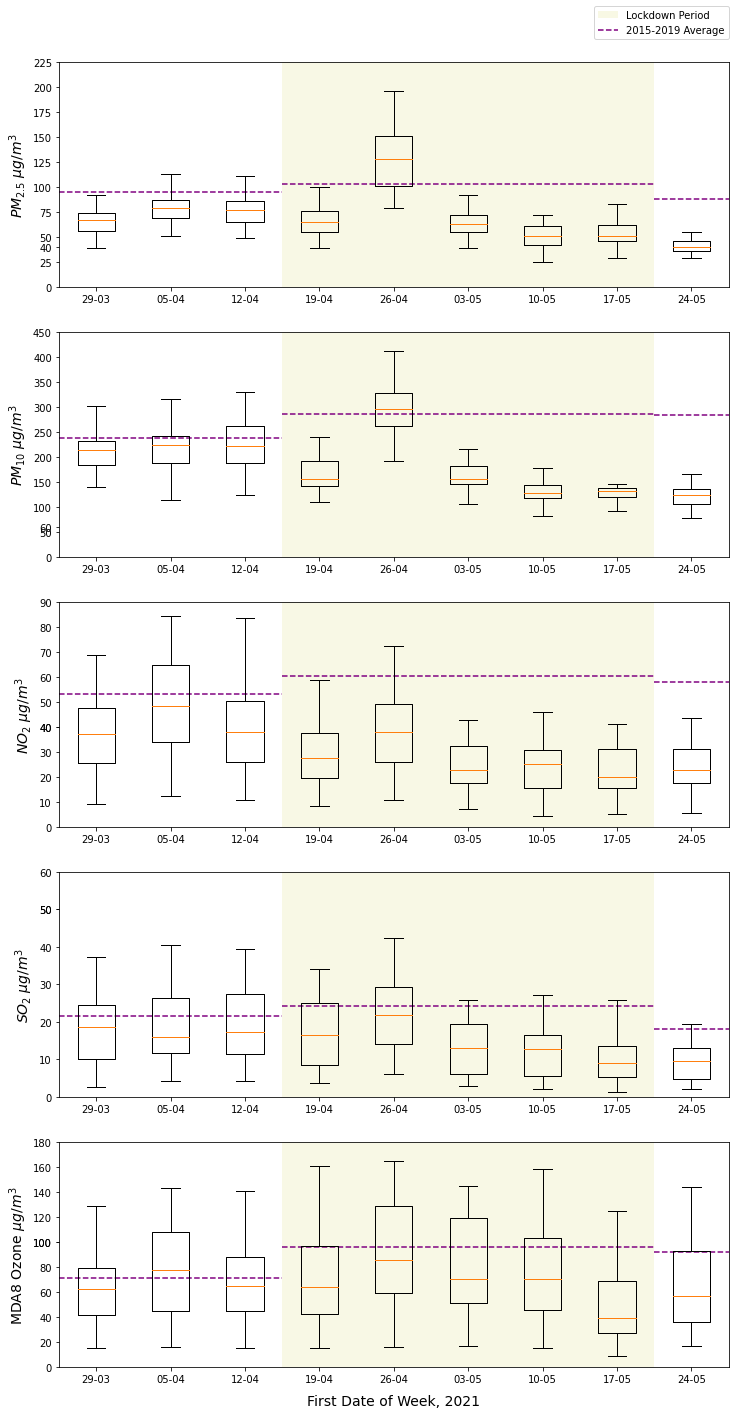

In [102]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
fig, axs = plt.subplots(5, figsize=(12, 24))

for i in range(5):
    avgs = defaultdict(list)
    for station in station_data:
        if pollutants[i] in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutants[i]].loc['2021-03-29':'2021-05-30']
            weekly_avgs = daily_avgs.resample('7D').apply(at_least_one)
            dates = weekly_avgs.index
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)
        
    prev_avgs = defaultdict(list)
    for year in range(2015, 2020):
        s1 = str(year) + '-03-29'
        e1 = str(year) + '-04-18'
        prev_avgs['pre-ld'].append(holistic['daily'][pollutants[i]]['mean'].loc[s1:e1])
        s2 = str(year) + '-04-19'
        e2 = str(year) + '-05-24'
        prev_avgs['ld'].append(holistic['daily'][pollutants[i]]['mean'].loc[s2:e2])
        s3 = str(year) + '-05-25'
        e3 = str(year) + '-05-31'
        prev_avgs['post-ld'].append(holistic['daily'][pollutants[i]]['mean'].loc[s3:e3])
    
    five_year_avgs = defaultdict(list)
    for year_vals in prev_avgs['pre-ld']:
        five_year_avgs['pre-ld'].append(year_vals.mean())
    
    for year_vals in prev_avgs['ld']:
        five_year_avgs['ld'].append(year_vals.mean())
    
    for year_vals in prev_avgs['post-ld']:
        five_year_avgs['post-ld'].append(year_vals.mean())
        
    preld_lim = at_least_one(five_year_avgs['pre-ld'])
    ld_lim = at_least_one(five_year_avgs['ld'])
    postld_lim = at_least_one(five_year_avgs['post-ld'])

    axs[i].boxplot(avgs_list, showfliers=False)

    gaps = axs[i].get_yticks()
    gap = (gaps[1] - gaps[0]) // 2

    top = max([axs[i].get_ylim()[1], standards[pollutants[i]] + gap, preld_lim + gap, \
               ld_lim + gap, postld_lim + gap])
    
    axs[i].set_ylim(0, top)
    axs[i].set_yticks(list(axs[i].get_yticks()) + [standards[pollutants[i]]])
    axs[i].set_ylabel(pol_labels[i] + ' $µg/m^3$', fontsize=14)
    
    axs[i].set_xticks([r for r in range(1, len(dates)+1)])
    axs[i].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])

    axs[i].axvspan(3.5,  8.5, facecolor='y', alpha=0.10, label='Lockdown Period')
    '''axs[i].hlines(y=standards[pollutants[i]], xmin=0.5, xmax=axs[i].get_xticks()[-1]+0.5, 
                  color='blue', linestyles='dashed', label='CPCB Standard', linewidth=1.5)'''
    '''axs[i].hlines(y=five_year_means[pollutants[i]], xmin=axs[i].get_xlim()[0], xmax=axs[i].get_xlim()[1], 
                  color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5)'''
    
    axs[i].hlines(y=at_least_one(five_year_avgs['pre-ld']), xmin=0.5, xmax=3.5, 
                  color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5)
    axs[i].hlines(y=at_least_one(five_year_avgs['ld']), xmin=3.5, xmax=8.5, 
                  color='purple', linestyles='dashed', linewidth=1.5)
    axs[i].hlines(y=at_least_one(five_year_avgs['post-ld']), xmin=8.5, xmax=9.5, 
                  color='purple', linestyles='dashed', linewidth=1.5)
    
    '''axs[i].text(x=axs[i].get_xticks()[-1]+0.6, y=five_year_means[pollutants[i]], 
                s=str(round(five_year_means[pollutants[i]], 2)), color='purple')
    axs[i].text(x=axs[i].get_xticks()[-1]+0.6, y=standards[pollutants[i]], 
                s=str(standards[pollutants[i]]), color='blue')'''
    
    if pollutants[i] == 'PM2.5':
        axs[i].legend(bbox_to_anchor=(1.008, 1.27), loc='upper right')
    
    '''axs[i].vlines(x=3.5, ymin=0, ymax=axs[i].get_yticks()[-2], color='r', linestyles='solid', 
                  label='Beginning of Lockdown')
    axs[i].vlines(x=8.5, ymin=0, ymax=axs[i].get_yticks()[-2], color='r', linestyles='solid', 
                  label='Beginning of Lockdown')'''
    
    '''if pollutants[i] == 'PM2.5':
        axs[i].legend(bbox_to_anchor=(0.89, 1.25), loc='upper center')'''

fig_title = '2021_Lockdown_Weekly_Avg_Box_Plot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.xlabel('First Date of Week, 2021', fontsize=14, labelpad=10)
plt.show()

## Total averages before, during, and after 2021 lockdown

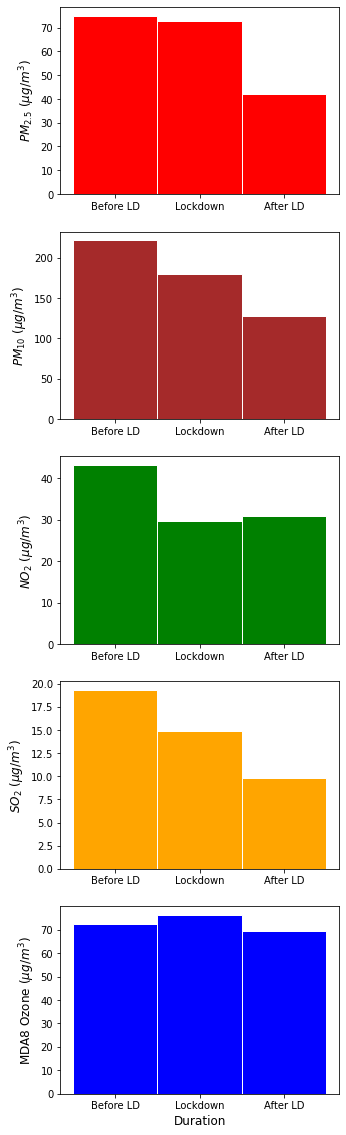

In [42]:
colors = ['red', 'brown', 'green', 'orange', 'blue']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

avgs = defaultdict(list)
for pollutant in holistic['daily'].keys():
    dat = holistic['daily'][pollutant]['mean'].loc['2021-03-29':'2021-05-31']
    avgs[pollutant].append(dat.loc['2021-03-29':'2021-04-18'].mean())
    avgs[pollutant].append(dat.loc['2021-04-19':'2021-05-23'].mean())
    avgs[pollutant].append(dat.loc['2021-05-24':'2021-05-31'].mean())

fig, axs = plt.subplots(5, 1, figsize=(5, 20))

for pollutant, ax, color in zip(list(avgs.keys()), axs, colors):
    ax.bar(x=list(range(3)), height=avgs[pollutant], width=1, color=color, edgecolor='white')
    ax.set_xticks(list(range(3)))
    ax.set_xticklabels(['Before LD', 'Lockdown', 'After LD'])
    ax.set_ylabel(pol_labels_dict[pollutant] + ' ($µg/m^3$)', fontsize=12)
    if pollutant == 'Ozone':
        ax.set_xlabel('Duration', fontsize=12)
    
fig_title = 'Avgs_During_LD_Dates_2021.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Make boxplots of weekly averages surrounding 2020 lockdown, based on individual pollutant

In [33]:
def make2020WeeklyBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return

    dates = ['2020-03-08',
             '2020-03-15',
             '2020-03-22',
             '2020-03-29',
             '2020-04-05',
             '2020-04-12',
             '2020-04-19',
             '2020-04-26',
             '2020-05-03']
    dates = pd.to_datetime(dates)
    avgs = {}
    for date in dates:
        avgs[date] = []

    max_y_val = 0
    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            daily_avgs = station_data[station]['daily'][pollutant].loc['2020-03-02':'2020-05-03']
            weekly_avgs = daily_avgs.resample('W').apply(at_least_one)
            if max(weekly_avgs) > max_y_val:
                max_y_val = max(weekly_avgs)
            for date in dates:
                avgs[date].append(weekly_avgs[date])

    avgs_list = []
    for date in avgs:
        curr_list = [x for x in avgs[date] if math.isnan(x) == False]
        avgs_list.append(curr_list)
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.boxplot(avgs_list)
    ax.set_title(pollutant + ' Over Delhi\nWeekly Averages Before and During Lockdown', fontsize=14)
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Last Date of Week', fontsize=14, labelpad=10)
    
    dates = ['2020-03-08',
             '2020-03-15',
             '2020-03-22',
             '2020-03-29',
             '2020-04-05',
             '2020-04-12',
             '2020-04-19',
             '2020-04-26',
             '2020-05-03']
    
    plt.axvline(x=3.5, color='r', label='Beginning of Lockdown Period')
    # plt.vlines(x=3.5, ymin=0, ymax=500, color='r', linestyles='solid', 
               # label='Beginning of Lockdown Period')
    standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}
    
    plt.hlines(y=standards[pollutant], xmin=0.5, xmax=9.5, color='b', linestyles='dashed',
               label='CPCB Standard')
    plt.xticks([r for r in range(1, len(dates)+1)], dates)
    plt.yticks(list(plt.yticks()[0]) + [standards[pollutant]])
    
    fig_title = pollutant + '_Weekly_Box_Plot.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    plt.legend(loc='upper right')
    plt.show()

## Make boxplot of weekly averages surrounding the dates of the 2020 lockdown period for each year from 2015 to 2021

In [443]:
def compareLockdown2020wBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = {}
    for station in df_daily.columns:
        for i in range(4):
            start_date = str(2018 + i) + '-03-24'
            end_date = str(2018 + i) + '-05-03'
            if i in avgs:
                avgs[i].append(at_least_one(df_daily[station][start_date:end_date]))
            else:
                avgs[i] = [at_least_one(df_daily[station][start_date:end_date])]
           
    avgs_list = []
    for i in range(4):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(14, 9))
    bp = ax.boxplot(avgs_list)
    
    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 5):
        ax.text(tick+0.25, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)
    
    ax.set_title('Average Levels of ' + pollutant + ' from\nMarch 24-May 3 (Dates of 2020 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([x for x in range(1, 5)], [x for x in range(2018, 2022)])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

## Make boxplot of weekly averages surrounding the dates of the 2021 lockdown period for each year from 2015 to 2021

In [242]:
def compareLockdown2021wBoxPlot(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    daily_index = station_data['Alipur']['daily'].index
    df_daily = pd.DataFrame(index=daily_index)

    for station in station_data:
        if pollutant in station_data[station]['daily'].columns:
            df_daily[station] = station_data[station]['daily'][pollutant]

    avgs = {}
    for station in df_daily.columns:
        for i in range(4):
            start_date = str(2018 + i) + '-04-19'
            end_date = str(2018 + i) + '-05-31'
            if i in avgs:
                avgs[i].append(at_least_one(df_daily[station][start_date:end_date]))
            else:
                avgs[i] = [at_least_one(df_daily[station][start_date:end_date])]
           
    avgs_list = []
    for i in range(4):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        avgs_list.append(avgs[i])
        
    if pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    fig, ax = plt.subplots(figsize=(14, 9))
    bp = ax.boxplot(avgs_list)
    
    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 5):
        ax.text(tick+0.25, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)
    
    ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylabel(pollutant + ' $µg/m^3$', fontsize=14)
    ax.set_xlabel('Duration', fontsize=14)
    plt.xticks([x for x in range(1, 5)], [x for x in range(2018, 2022)])

    fig_title = pollutant + 'BoxPlot.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

## Boxplots comparing MAM averages during each year from 2015 to 2021

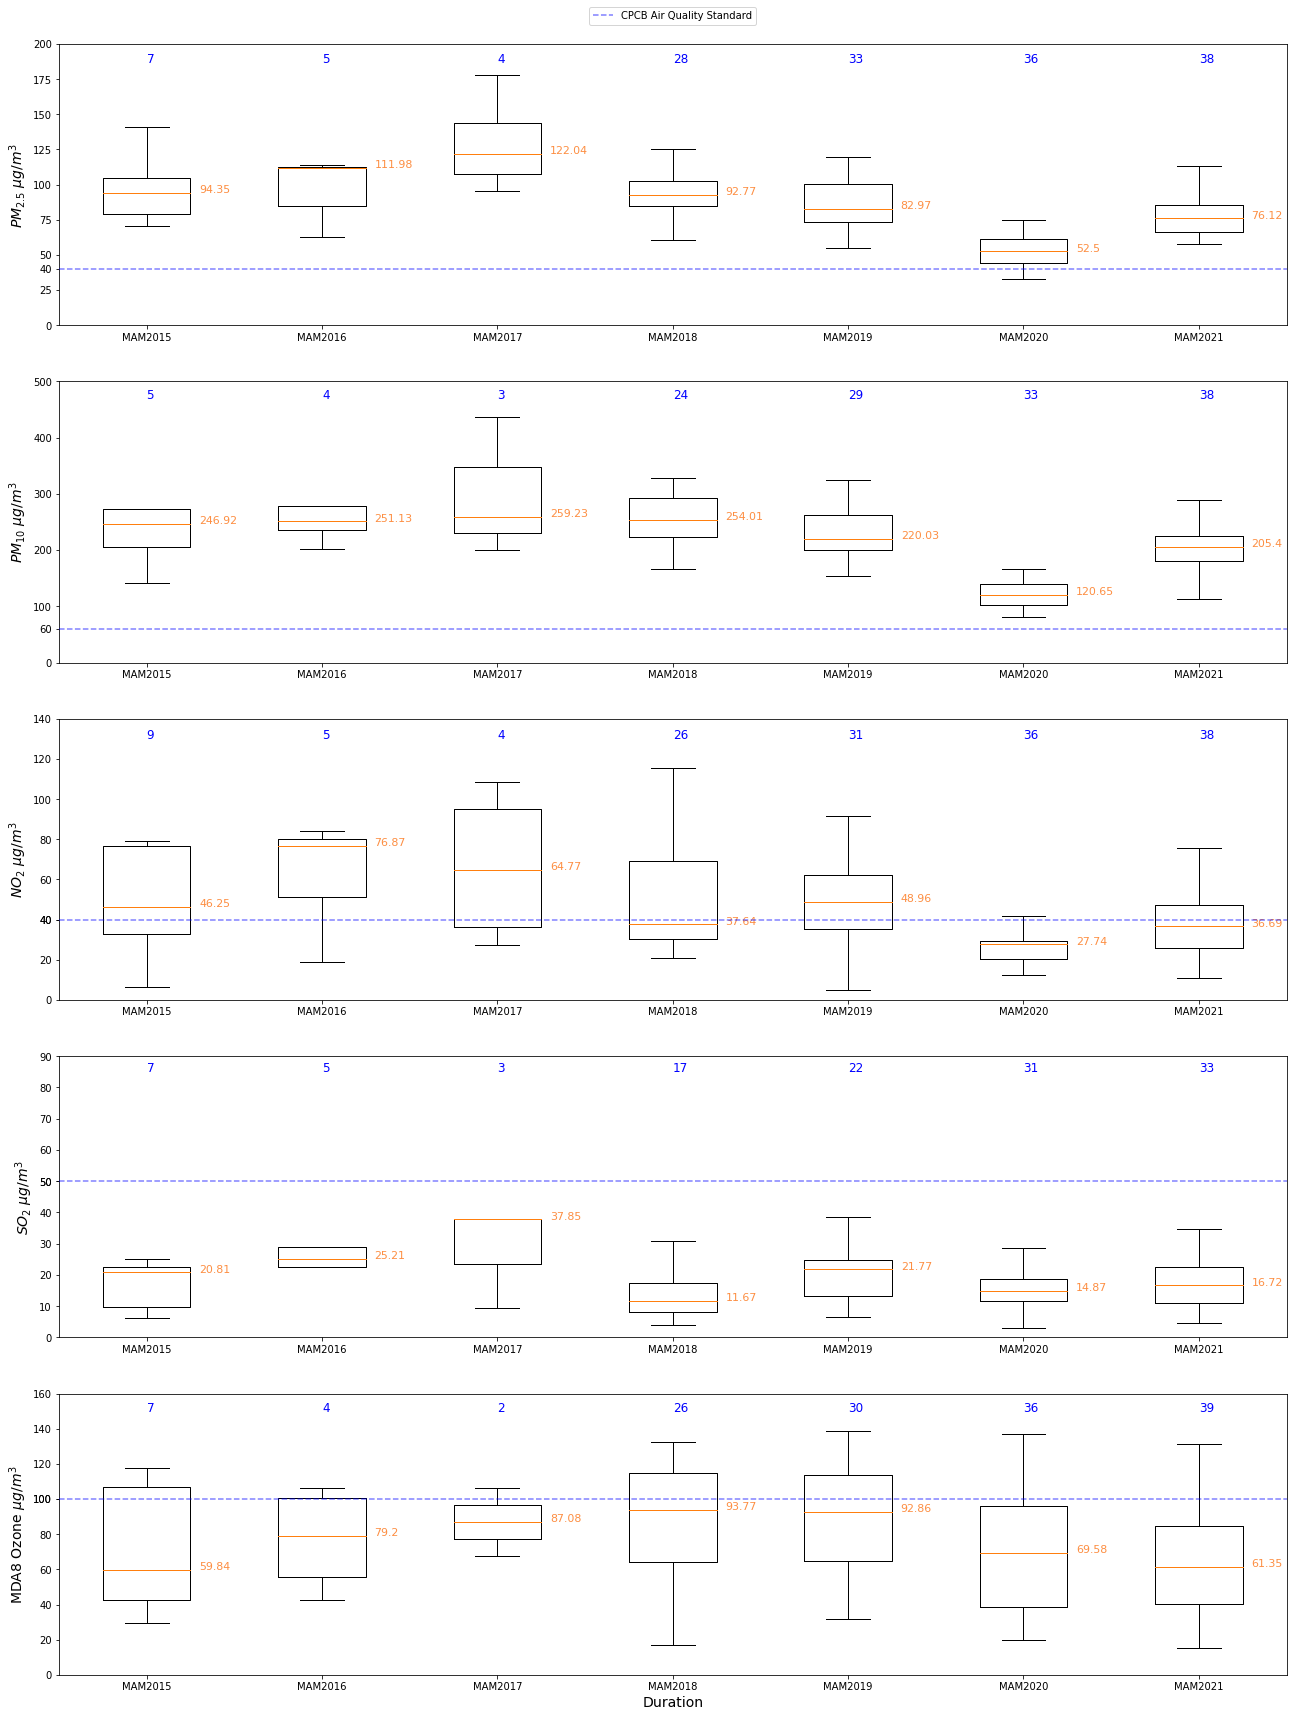

In [29]:
fig, axs = plt.subplots(5, figsize=(22, 30))
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
y_limits = {'PM2.5':187, 'PM10':470, 'NO2':130, 'SO2':85, 'Ozone':150}

for pollutant, pol_label, ax in zip(pollutants, pol_labels, axs):
    avgs = {}
    num_stations = {}
    
    for station in station_data:
        if pollutant not in station_data[station]['seasonal'].columns:
            continue
        for i in range(7):
            season_index = 'MAM' + str(2015 + i)
            if i in avgs:
                avgs[i].append(station_data[station]['seasonal'][pollutant][season_index])
            else:
                avgs[i] = [station_data[station]['seasonal'][pollutant][season_index]]

    avgs_list = []
    for i in range(7):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        num_stations[i] = len(avgs[i])
        avgs_list.append(avgs[i])

    bp = ax.boxplot(avgs_list, showfliers=False)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 8):
        ax.text(tick+0.3, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)

    top = ax.get_ylim()[1]
    if standards[pollutant] > top:
        top = standards[pollutant] + 40
        
    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylim(0, top)
    ax.set_ylabel(pol_label + ' $µg/m^3$', fontsize=14)
    ax.set_yticks(list(ax.get_yticks()) + [standards[pollutant]])
    ax.set_xticks([x for x in range(1, 8)])
    ax.set_xticklabels([('MAM'+str(x)) for x in range(2015, 2022)])
    ax.hlines(y=standards[pollutant], xmin=0.5, xmax=7.5, color='blue', linestyles='dashed',
              label='CPCB Air Quality Standard', zorder=10, alpha=0.5)
    
    # placement = ax.get_yticks()[-2] - ((ax.get_yticks()[-2] - ax.get_yticks()[-3]) // 2)
    
    for tick in range(1, 8):
        ax.text(tick, y_limits[pollutant], num_stations[tick-1], color='blue', fontsize=12)
    
    if pollutant == 'PM2.5':
        # ax.set_title('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=16, pad=50)
        ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center')

# plt.xticks([x for x in range(1, 7)], [('MAM'+str(x)) for x in range(2016, 2022)], fontsize=14)
plt.xlabel('Duration', fontsize=14)
#fig.suptitle('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=18)
#fig.tight_layout(rect=[0, 0, 1, 0.97])

fig_title = 'MAM_BoxPlot_7.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.show()

## Boxplots comparing MAM averages, combining 2015-2019 averages into a single boxplot

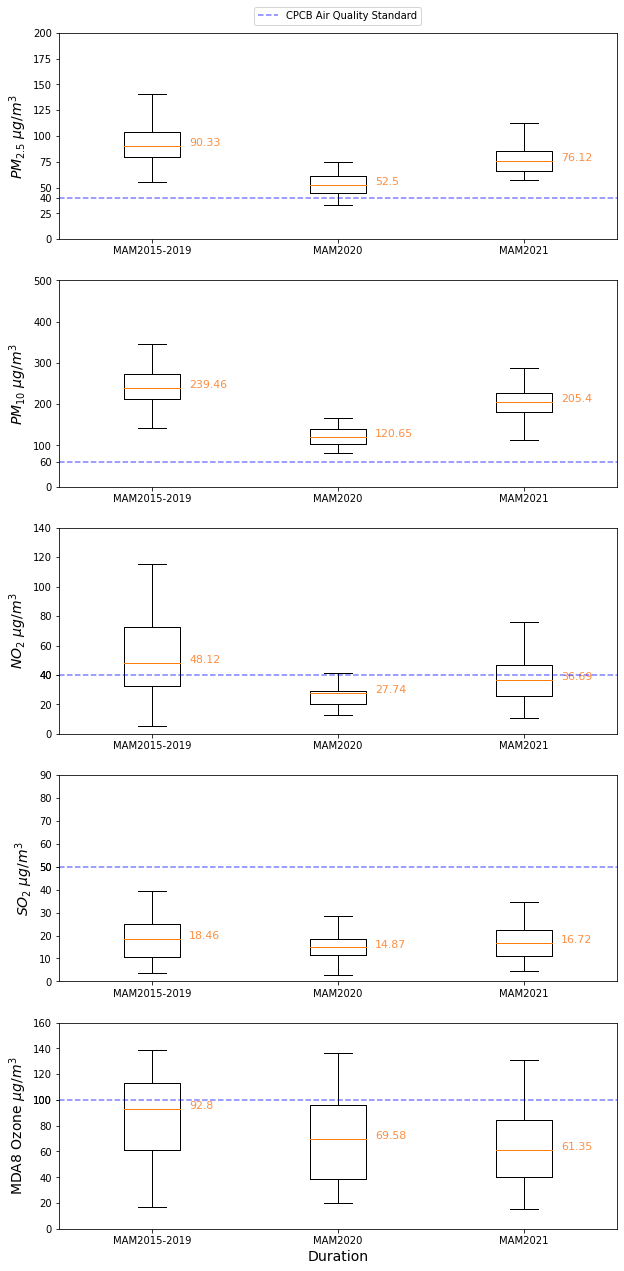

In [28]:
fig, axs = plt.subplots(5, figsize=(10, 22))
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
y_limits = {'PM2.5':200, 'PM10':500, 'NO2':140, 'SO2':90, 'Ozone':160}

for pollutant, pol_label, ax in zip(pollutants, pol_labels, axs):
    avgs = {}
    
    for station in station_data:
        if pollutant not in station_data[station]['seasonal'].columns:
            continue
        for i in range(7):
            season_index = 'MAM' + str(2015 + i)
            if i in avgs:
                avgs[i].append(station_data[station]['seasonal'][pollutant][season_index])
            else:
                avgs[i] = [station_data[station]['seasonal'][pollutant][season_index]]

    avgs_list  = []
    prev_years = []
    for i in range(5):
        avgs[i] = [x for x in avgs[i] if math.isnan(x) == False]
        prev_years += avgs[i]
    avgs_list.append(prev_years)
    
    avgs[5] = [x for x in avgs[5] if math.isnan(x) == False]
    avgs_list.append(avgs[5])
    avgs[6] = [x for x in avgs[6] if math.isnan(x) == False]
    avgs_list.append(avgs[6])

    bp = ax.boxplot(avgs_list, showfliers=False)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 4):
        ax.text(tick+0.2, medians[tick-1], upper_labels[tick-1], color=(0.992, 0.557, 0.259), fontsize=11)
        
    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylim(0, y_limits[pollutant])
    ax.set_ylabel(pol_label + ' $µg/m^3$', fontsize=14)
    ax.set_yticks(list(ax.get_yticks()) + [standards[pollutant]])
    ax.set_xticks([x for x in range(1, 4)])
    ax.set_xticklabels(['MAM2015-2019', 'MAM2020', 'MAM2021'])
    ax.hlines(y=standards[pollutant], xmin=0.5, xmax=3.5, color='blue', linestyles='dashed',
              label='CPCB Air Quality Standard', alpha=0.5, zorder=10)
    
    if pollutant == 'PM2.5':
        # ax.set_title('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=16, pad=50)
        ax.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center')

# plt.xticks([x for x in range(1, 7)], [('MAM'+str(x)) for x in range(2016, 2022)], fontsize=14)
plt.xlabel('Duration', fontsize=14)
#fig.suptitle('Average Pollutant Levels during March-April-May, 2018-2021', fontsize=18)
#fig.tight_layout(rect=[0, 0, 1, 0.97])

fig_title = 'MAM_BoxPlot_3.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.show()

## Boxplots comparing 2020 and 2021 lockdown averages, using various periods of lockdown

### Complete lockdown (March 25 - May 31, 2020 vs. April 19 - May 24, 2021)

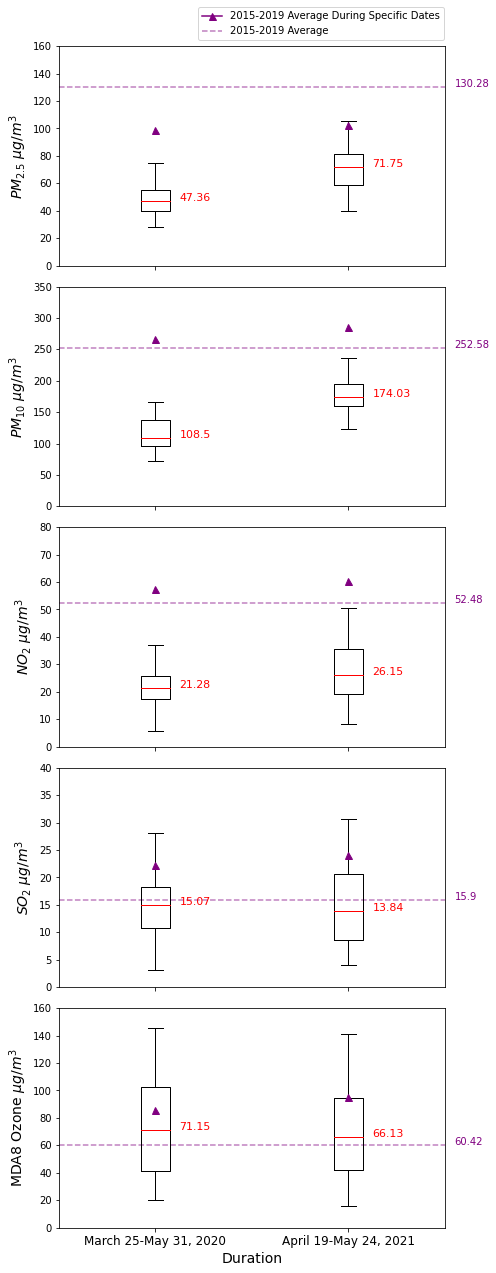

In [47]:
fig, axs = plt.subplots(5, figsize=(7, 18), sharex=True)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'NO2':40, 'SO2':50, 'Ozone':100}
y_limits = {'PM2.5':160, 'PM10':350, 'NO2':80, 'SO2':40, 'Ozone':160}

for pollutant, pol_label, ax in zip(pollutants, pol_labels, axs):
    avgs_2020 = []
    avgs_2021 = []
    for station in station_data:
        if pollutant not in station_data[station]['daily'].columns:
            continue
        ld_mean_2020 = station_data[station]['daily'].loc['2020-03-25':'2020-05-31', pollutant].mean()
        ld_mean_2021 = station_data[station]['daily'].loc['2021-04-19':'2021-05-24', pollutant].mean()
        if not math.isnan(ld_mean_2020):
            avgs_2020.append(ld_mean_2020)
        if not math.isnan(ld_mean_2021):
            avgs_2021.append(ld_mean_2021)

    avgs_list = [avgs_2020, avgs_2021]

    medianprops = dict(color='red')
    bp = ax.boxplot(avgs_list, medianprops=medianprops, showfliers=False)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 3):
        ax.text(tick+0.125, medians[tick-1], upper_labels[tick-1], color='red', fontsize=11)

    years = ['2015', '2016', '2017', '2018', '2019']
    prev_avg_2020_list = []
    prev_avg_2021_list = []
    for year in years:
        dat_2020 = holistic['daily'][pollutant].loc[year+'-03-25':year+'-05-31', 'mean']
        dat_2021 = holistic['daily'][pollutant].loc[year+'-04-19':year+'-05-24', 'mean']
        prev_avg_2020_list.append(dat_2020.mean())
        prev_avg_2021_list.append(dat_2021.mean())
    prev_avg_2020 = at_least_one(prev_avg_2020_list)
    prev_avg_2021 = at_least_one(prev_avg_2021_list)
    
    ax.plot(1, prev_avg_2020, marker='^', markersize=7, color='purple', 
            label='2015-2019 Average During Specific Dates')
    ax.plot(2, prev_avg_2021, marker='^', markersize=7, color='purple')
        
    ax.hlines(y=five_year_means[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
              color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5, alpha=0.5)
    ax.text(x=ax.get_xticks()[-1]+0.55, y=five_year_means[pollutant], 
            s=str(round(five_year_means[pollutant], 2)), color='purple')
    
    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylim(0, y_limits[pollutant])
    ax.set_ylabel(pol_label + ' $µg/m^3$', fontsize=14)
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
    
    '''
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during Respective\n' +
                     'Lockdown Periods in 2020 and 2021', fontsize=14)
    '''
plt.xticks([x for x in range(1, 3)], ['March 25-May 31, 2020', 'April 19-May 24, 2021'], fontsize=12)
plt.xlabel('Duration', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])
fig_title = 'CompleteLockdownComparisonBoxPlot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.show()

### Shared lockdown (April 19 - May 24, 2020 vs. April 19 - May 24, 2021)

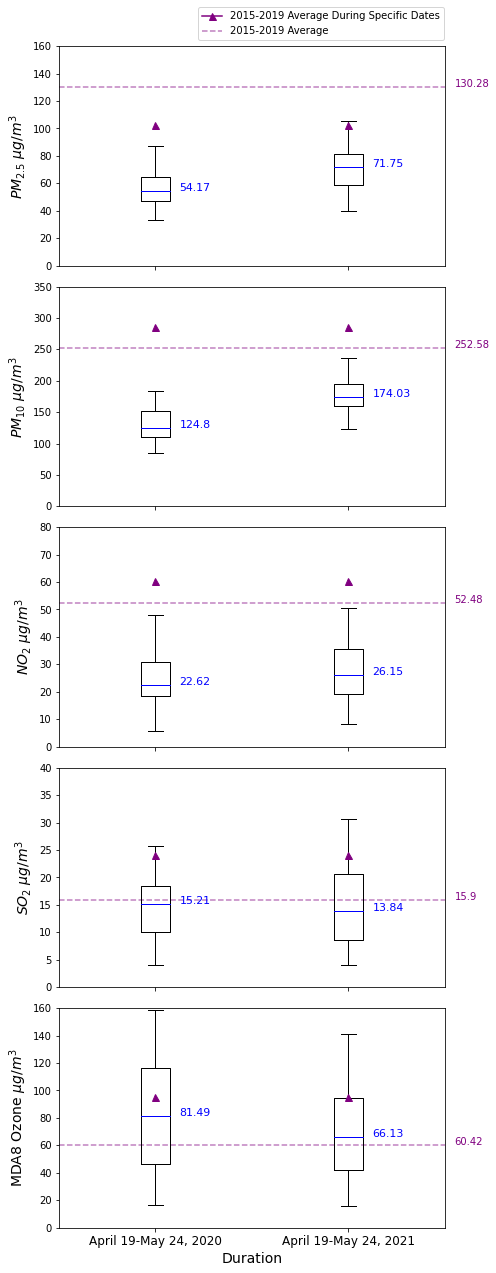

In [48]:
fig, axs = plt.subplots(5, figsize=(7, 18), sharex=True)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
y_limits = {'PM2.5':160, 'PM10':350, 'NO2':80, 'SO2':40, 'Ozone':160}

for pollutant, pol_label, ax in zip(pollutants, pol_labels, axs):
    avgs_2020 = []
    avgs_2021 = []
    for station in station_data:
        if pollutant not in station_data[station]['daily'].columns:
            continue
        ld_mean_2020 = station_data[station]['daily'].loc['2020-04-19':'2020-05-24', pollutant].mean()
        ld_mean_2021 = station_data[station]['daily'].loc['2021-04-19':'2021-05-24', pollutant].mean()
        if not math.isnan(ld_mean_2020):
            avgs_2020.append(ld_mean_2020)
        if not math.isnan(ld_mean_2021):
            avgs_2021.append(ld_mean_2021)

    avgs_list = [avgs_2020, avgs_2021]

    medianprops = dict(color='blue')
    bp = ax.boxplot(avgs_list, medianprops=medianprops, showfliers=False)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 3):
        ax.text(tick+0.125, medians[tick-1], upper_labels[tick-1], color='blue', fontsize=11)

    years = ['2015', '2016', '2017', '2018', '2019']
    prev_avg_list = []
    for year in years:
        dat = holistic['daily'][pollutant].loc[year+'-04-19':year+'-05-24', 'mean']
        prev_avg_list.append(dat.mean())
    prev_avg = at_least_one(prev_avg_list)
    
    ax.plot(1, prev_avg, marker='^', markersize=7, color='purple', 
            label='2015-2019 Average During Specific Dates')
    ax.plot(2, prev_avg, marker='^', markersize=7, color='purple')
        
    ax.hlines(y=five_year_means[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
              color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5, alpha=0.5)
    ax.text(x=ax.get_xticks()[-1]+0.55, y=five_year_means[pollutant], 
            s=str(round(five_year_means[pollutant], 2)), color='purple')
    
    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylim(0, y_limits[pollutant])
    ax.set_ylabel(pol_label + ' $µg/m^3$', fontsize=14)
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
    
    '''
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during Respective\n' +
                     'Lockdown Periods in 2020 and 2021', fontsize=14)
    '''
plt.xticks([x for x in range(1, 3)], ['April 19-May 24, 2020', 'April 19-May 24, 2021'], fontsize=12)
plt.xlabel('Duration', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])
fig_title = 'SharedLockdownComparisonBoxPlot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.show()

### Relative severity lockdown (May 4 - May 31, 2020 vs. April 19 - May 24, 2021)

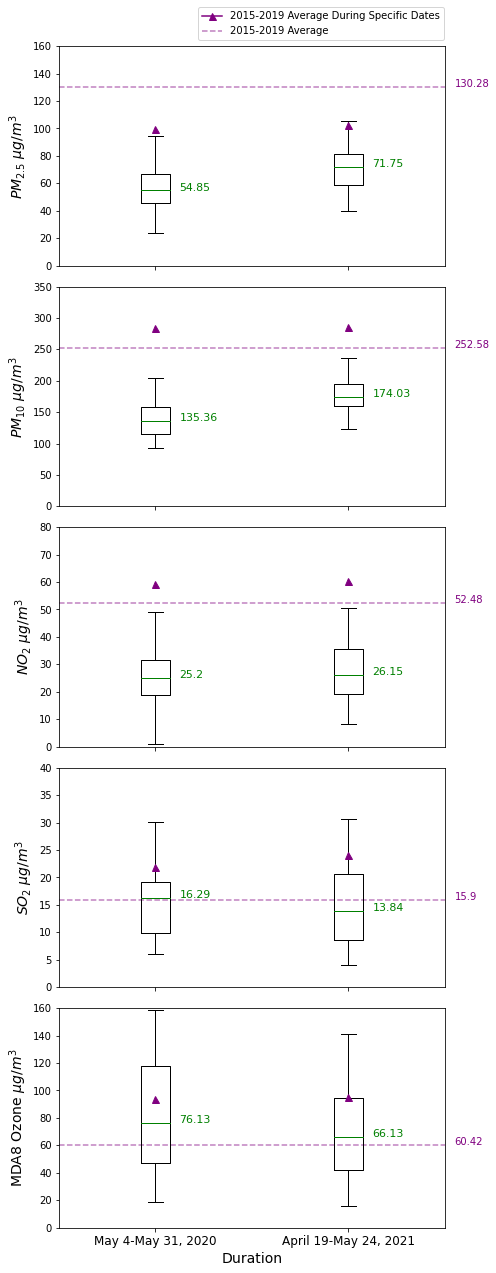

In [49]:
fig, axs = plt.subplots(5, figsize=(7, 18), sharex=True)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels = ['$PM_{2.5}$', '$PM_{10}$', '$NO_2$', '$SO_2$', 'MDA8 Ozone']
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}
y_limits = {'PM2.5':160, 'PM10':350, 'NO2':80, 'SO2':40, 'Ozone':160}

for pollutant, pol_label, ax in zip(pollutants, pol_labels, axs):
    avgs_2020 = []
    avgs_2021 = []
    for station in station_data:
        if pollutant not in station_data[station]['daily'].columns:
            continue
        ld_mean_2020 = station_data[station]['daily'].loc['2020-05-04':'2020-05-31', pollutant].mean()
        ld_mean_2021 = station_data[station]['daily'].loc['2021-04-19':'2021-05-24', pollutant].mean()
        if not math.isnan(ld_mean_2020):
            avgs_2020.append(ld_mean_2020)
        if not math.isnan(ld_mean_2021):
            avgs_2021.append(ld_mean_2021)

    avgs_list = [avgs_2020, avgs_2021]

    medianprops = dict(color='green')
    bp = ax.boxplot(avgs_list, medianprops=medianprops, showfliers=False)

    medians = []
    for medline in bp['medians']:
        linedata = medline.get_ydata()
        medians.append(linedata[0])
    upper_labels = [str(round(s, 2)) for s in medians]
    for tick in range(1, 3):
        ax.text(tick+0.125, medians[tick-1], upper_labels[tick-1], color='green', fontsize=11)

    years = ['2015', '2016', '2017', '2018', '2019']
    prev_avg_2020_list = []
    prev_avg_2021_list = []
    for year in years:
        dat_2020 = holistic['daily'][pollutant].loc[year+'-05-04':year+'-05-31', 'mean']
        dat_2021 = holistic['daily'][pollutant].loc[year+'-04-19':year+'-05-24', 'mean']
        prev_avg_2020_list.append(dat_2020.mean())
        prev_avg_2021_list.append(dat_2021.mean())
    prev_avg_2020 = at_least_one(prev_avg_2020_list)
    prev_avg_2021 = at_least_one(prev_avg_2021_list)
    
    ax.plot(1, prev_avg_2020, marker='^', markersize=7, color='purple', 
            label='2015-2019 Average During Specific Dates')
    ax.plot(2, prev_avg_2021, marker='^', markersize=7, color='purple')
        
    ax.hlines(y=five_year_means[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
              color='purple', linestyles='dashed', label='2015-2019 Average', linewidth=1.5, alpha=0.5)
    ax.text(x=ax.get_xticks()[-1]+0.55, y=five_year_means[pollutant], 
            s=str(round(five_year_means[pollutant], 2)), color='purple')
    
    # ax.set_title('Average Levels of ' + pollutant + ' from\nApril 19-May 31 (Dates of 2021 Lockdown Period)')
    ax.set_ylim(0, y_limits[pollutant])
    ax.set_ylabel(pol_label + ' $µg/m^3$', fontsize=14)
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
    
    '''
    if pollutant == 'PM2.5':
        ax.set_title('Average Pollutant Levels during Respective\n' +
                     'Lockdown Periods in 2020 and 2021', fontsize=14)
    '''
plt.xticks([x for x in range(1, 3)], ['May 4-May 31, 2020', 'April 19-May 24, 2021'], fontsize=12)
plt.xlabel('Duration', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])
fig_title = 'RelativeLockdownComparisonBoxPlot.tiff'
# plt.savefig(fig_title, bbox_inches="tight")

plt.show()

## Make line plots of weekly averages of individual pollutant during 2020 lockdown dates for each year from 2016 to 2021, showing trendlines

In [51]:
def compareWeeklyAverages2020(pollutant):
    
    slopes = []
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    dims = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    max_y = 0
    
    for i in range(len(years)):
        if pollutant == 'MDA8 Ozone':
            pollutant = 'Ozone'
        
        daily = holistic['daily'][pollutant].loc[years[i] + '-03-03':years[i] + '-04-28']
        weekly = daily.resample('7D').mean()
        dates = []
        for date in weekly.index:
            dates.append(str(date)[5:10])

        standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

        xd = np.arange(0, len(daily))
        daily.index = xd
        
        x = np.arange(0, len(daily), 7)
        weekly.index = x
        y = weekly
        m, b = np.polyfit(x, y, 1)
        slopes.append(m)

        dim1, dim2 = dims[i]
        m = round(m, 2)
        b = round(b, 2)
        equation = str(m) + 'x+' + str(b)
        
        # make the plot
        l1, = axs[dim1][dim2].plot(weekly[weekly.index[:4]], color='y', marker='o', 
                                   markersize=10, label='Before Lockdown')
        l2, = axs[dim1][dim2].plot(weekly[weekly.index[3:]], color='r', marker='o', 
                                   markersize=10, label='During Lockdown')
        axs[dim1][dim2].plot(daily, color='black', marker='o', alpha=0.10,
                             label='Daily Average')
        axs[dim1][dim2].plot(x, m*x + b, linewidth=3, linestyle='dashed', label=equation)
        axs[dim1][dim2].legend(loc='upper left')
        
        if pollutant == 'Ozone':
            pollutant = 'MDA8 Ozone'

        axs[dim1][dim2].set_xticks(x)
        axs[dim1][dim2].set_xticklabels(dates)
        if dim1 == 2:
            axs[dim1][dim2].set_xlabel('First Date of Week', fontsize=14, labelpad=10)
        if dim2 == 0:
            axs[dim1][dim2].set_ylabel('$µg/m^3$', fontsize=14)
        axs[dim1][dim2].set_title(years[i], fontsize=14)
        
        if axs[dim1][dim2].get_ylim()[1] > max_y:
            max_y = axs[dim1][dim2].get_ylim()[1]
        
    fig.suptitle('Comparing Weekly Averages of\n' + pollutant + \
                 ' Levels Before and During 2020 Lockdown Dates', fontsize=16) 
    
    fig_title = pollutant + '_Trendlines_2020_Lockdown_Dates.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    for dim1, dim2 in dims:
        axs[dim1][dim2].set_ylim(0, max_y+50)
        
    plt.subplots_adjust(bottom=-0.5)
    plt.show()
    return slopes

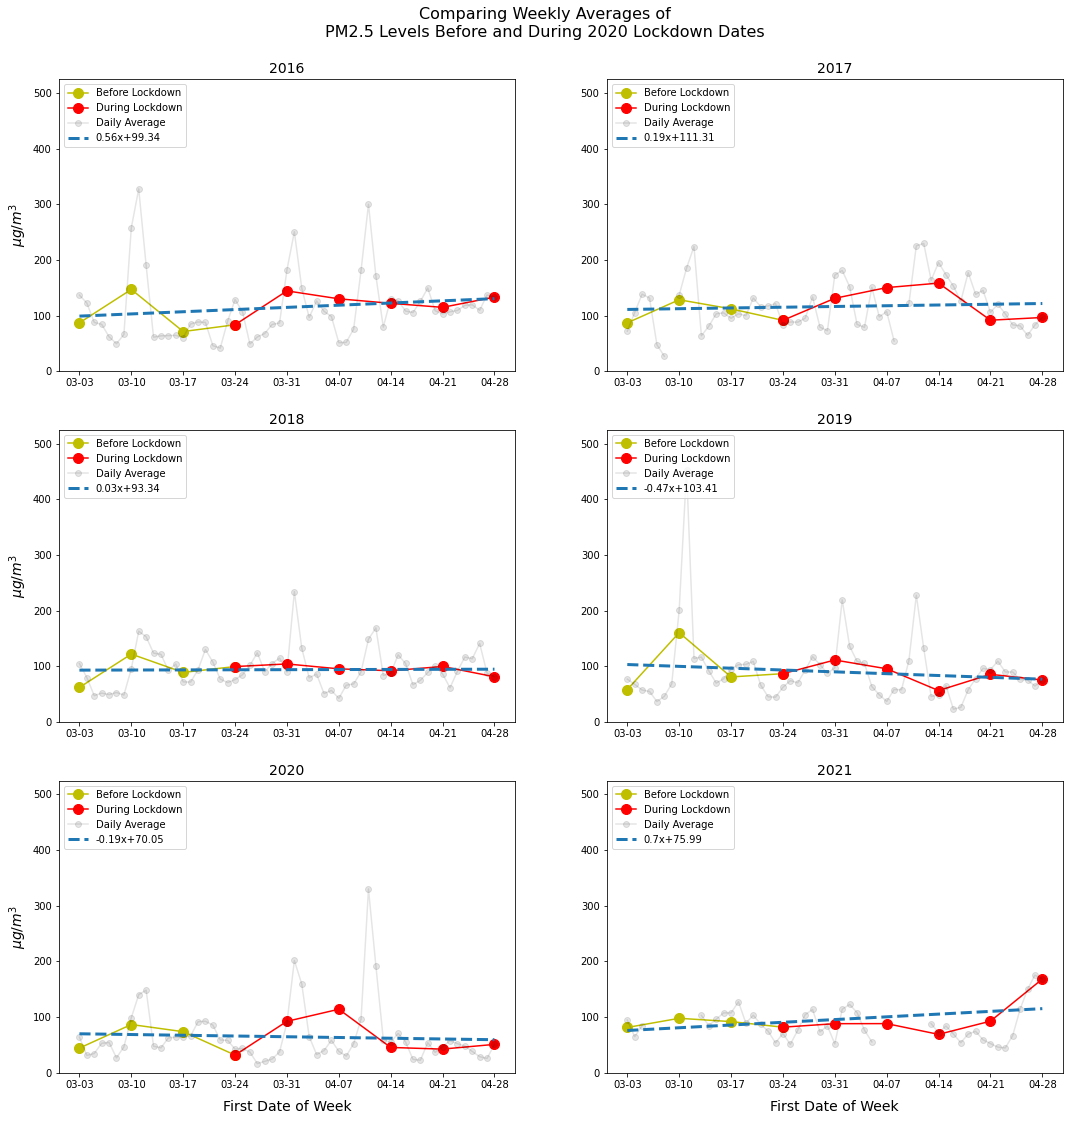

In [52]:
ms = compareWeeklyAverages2020('PM2.5')

### Plot bar graphs of slopes for each year shown above

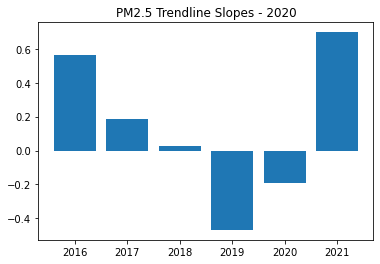

In [61]:
x_loc = [0, 1, 2, 3, 4, 5]
plt.bar(x_loc, ms)
plt.xticks(x_loc, [x for x in range(2016, 2022)])
plt.title('PM2.5 Trendline Slopes - 2020')
plt.show()

## Make line plots of weekly averages of individual pollutant during 2021 lockdown dates for each year from 2016 to 2021, showing trendlines

In [73]:
def compareWeeklyAverages2021(pollutant):
    
    slopes = []
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    dims = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    years = ['2016', '2017', '2018', '2019', '2020', '2021']
    max_y = 0
    
    for i in range(len(years)):
        if pollutant == 'MDA8 Ozone':
            pollutant = 'Ozone'
        
        daily = holistic['daily'][pollutant].loc[years[i] + '-03-29':years[i] + '-05-30']
        weekly = daily.resample('7D').mean()
        dates = []
        for date in weekly.index:
            dates.append(str(date)[5:10])

        standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'MDA8 Ozone':100}

        x = np.arange(0, len(weekly))
        weekly.index = x
        y = weekly
        m, b = np.polyfit(x, y, 1)
        slopes.append(m)

        dim1, dim2 = dims[i]
        m = round(m, 2)
        b = round(b, 2)
        equation = str(m) + 'x+' + str(b)
        
        # make the plot
        l1, = axs[dim1][dim2].plot(weekly[weekly.index[:4]], color='y', marker='o', label='Before Lockdown')
        l2, = axs[dim1][dim2].plot(weekly[weekly.index[3:]], color='r', marker='o', label='During Lockdown')
        axs[dim1][dim2].plot(x, m*x + b, label=equation)
        axs[dim1][dim2].legend(loc='upper left')
        
        if pollutant == 'Ozone':
            pollutant = 'MDA8 Ozone'

        axs[dim1][dim2].set_xticks(x)
        axs[dim1][dim2].set_xticklabels(dates)
        if dim1 == 2:
            axs[dim1][dim2].set_xlabel('First Date of Week', fontsize=14, labelpad=10)
        if dim2 == 0:
            axs[dim1][dim2].set_ylabel('$µg/m^3$', fontsize=14)
        axs[dim1][dim2].set_title(years[i], fontsize=14)
        
        if axs[dim1][dim2].get_ylim()[1] > max_y:
            max_y = axs[dim1][dim2].get_ylim()[1]
        
    fig.suptitle('Comparing Weekly Averages of\n' + pollutant + \
                 ' Levels Before and During 2021 Lockdown Dates', fontsize=16) 
    
    fig_title = pollutant + '_Trendlines_2021_Lockdown_Dates.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    for dim1, dim2 in dims:
        axs[dim1][dim2].set_ylim(0, max_y+50)
        
    plt.subplots_adjust(bottom=-0.5)
    plt.show()
    return slopes

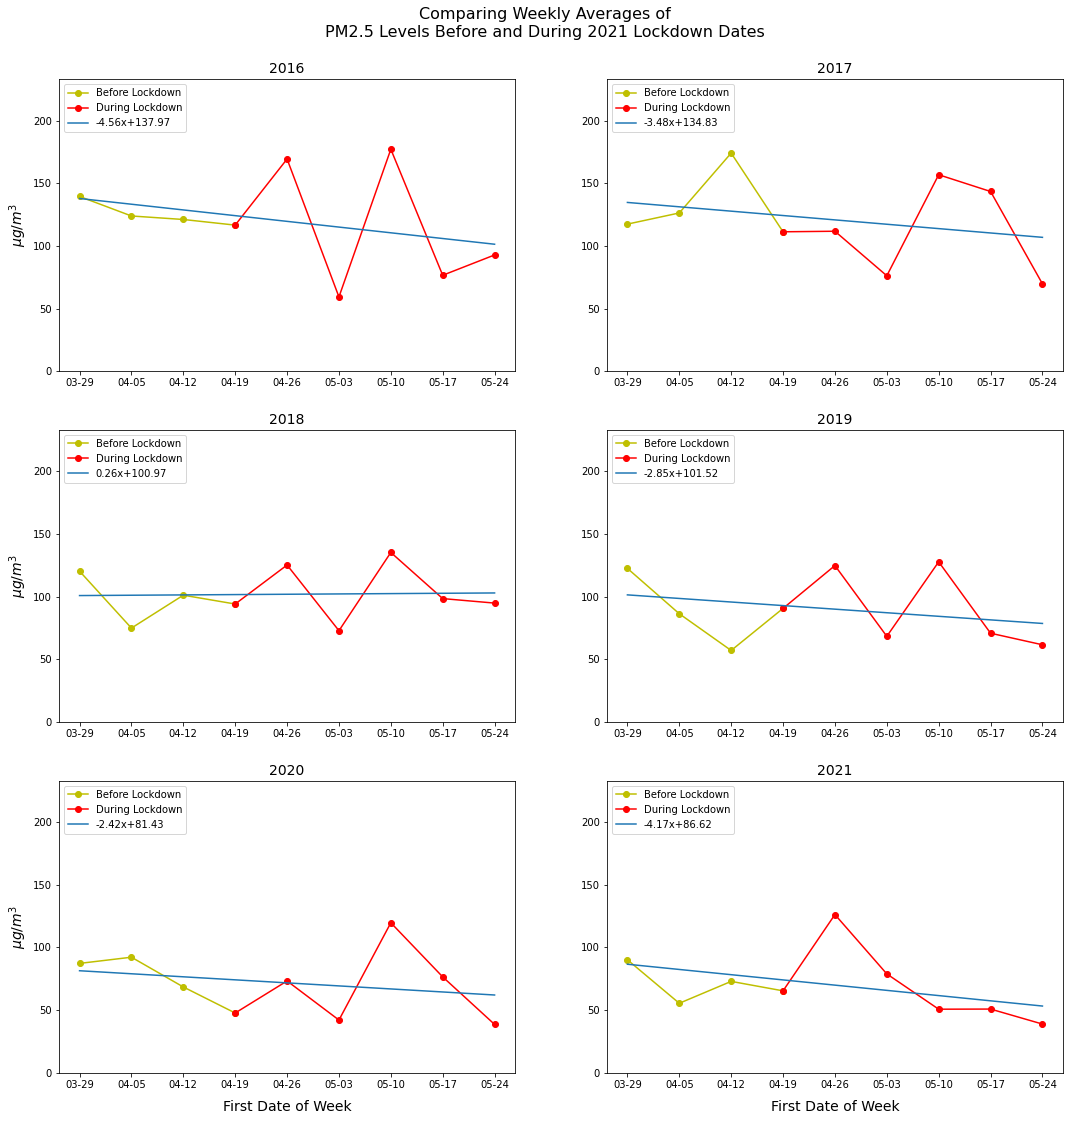

In [74]:
ms = compareWeeklyAverages2021('PM2.5')

### Plot bar graphs of slopes for each year shown above

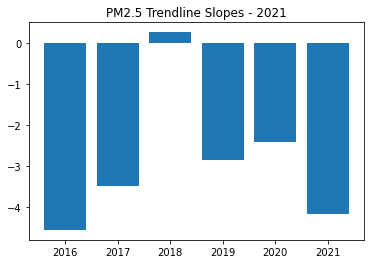

In [76]:
x_loc = [0, 1, 2, 3, 4, 5]
plt.bar(x_loc, ms)
plt.xticks(x_loc, [x for x in range(2016, 2022)])
plt.title('PM2.5 Trendline Slopes - 2021')
plt.show()

## Recreate bar graphs in Singh + Chauhan paper

In [40]:
# averages of species levels from March 22, 2020 - March 31, 2020
species_ld = [holistic['daily']['PM25'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['PM10'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['NO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['SO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['Ozone'].loc['2020-03-22':'2020-03-31'].mean()]

# March 2020 averages for each species
march_avgs = [holistic['monthly']['PM25'].loc['2020-03-31'],
              holistic['monthly']['PM10'].loc['2020-03-31'],
              holistic['monthly']['NO2'].loc['2020-03-31'],
              holistic['monthly']['SO2'].loc['2020-03-31'],
              holistic['monthly']['Ozone'].loc['2020-03-31']]

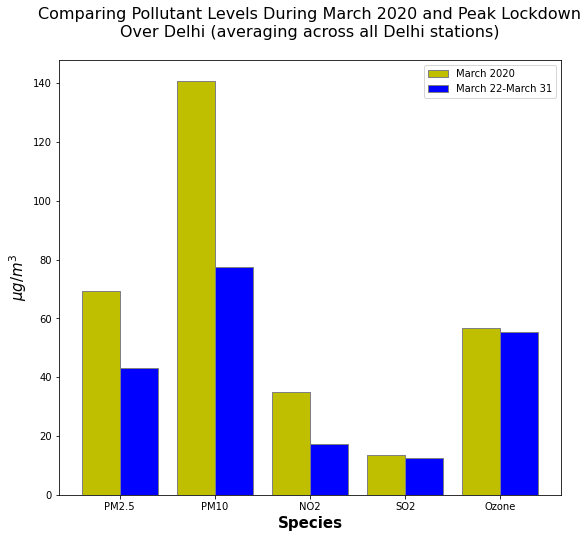

In [41]:
barWidth = 0.4
fig = plt.subplots(figsize =(9, 8))
 
# set position of bar on x-axis
br1 = np.arange(len(species_ld))
br2 = [x + barWidth for x in br1]
 
# make the plot
plt.bar(br1, march_avgs, color ='y', width = barWidth,
        edgecolor ='grey', label ='March 2020')
plt.bar(br2, species_ld, color ='b', width = barWidth,
        edgecolor ='grey', label ='March 22-March 31')

plt.xlabel('Species', fontweight ='bold', fontsize = 15)
plt.ylabel('$µg/m^3$', fontweight ='bold', fontsize = 15)
plt.xticks([r + (0.5*barWidth) for r in range(len(march_avgs))],
           ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone'])
plt.title('Comparing Pollutant Levels During March 2020 and Peak Lockdown\n' +
          'Over Delhi (averaging across all Delhi stations)\n', fontsize=16) 
plt.legend()
fig_title = 'Holistic_Lockdown_Comparison.tiff'
plt.savefig(fig_title, bbox_inches="tight")
plt.show()

## Plot hourly and monthly means by pollutant, averaged across all Delhi stations

In [118]:
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

def plotSpecies(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
        
    fig, ax = plt.subplots(figsize=(12,7))
          
    dat = holistic['hourly'][pollutant].loc[:'2021-05-31'] # df with hourly mean values
    y1  = dat.loc['2020-01-01':'2020-03-24']
    ld1 = dat.loc['2020-03-25':'2020-05-31']
    y2  = dat.loc['2020-06-01':'2021-04-18']
    ld2 = dat.loc['2021-04-19':'2021-05-31']
    mm  = holistic['monthly'][pollutant].loc['2020-01-31':'2021-05-31'] # df with monthly means
    indices = [pd.to_datetime(str(date)[0:8] + '01') for date in mm.index]
    mm.index = indices
    
    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, \
            label='Hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, \
            label='Hourly mean during lockdown')
    ax.plot(y2, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5)
    ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25)

    # Overlaying hourly mean values with monthly means
    ax.plot(mm, linestyle='--', color = 'black', linewidth='2.5') # monthly means as dotted lines
    ax.plot(mm, marker='o', markersize=10, linewidth=0,
            markerfacecolor='yellow',
            markeredgecolor='black',
            markeredgewidth=2, label='Monthly mean') # monthly means as yellow dot
        
    ax.set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    # ax.set_title(pol_labels_dict[pollutant] + ' Over Delhi (averaged across all Delhi stations)', fontsize=18)
    
    plt.legend(loc='upper left')
    
    fig_title = 'Timeseries_' + pollutant + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready:', fig_title)
    plt.show()    

## Visualize all hourly and monthly means from 2015-present, highlighting lockdowns

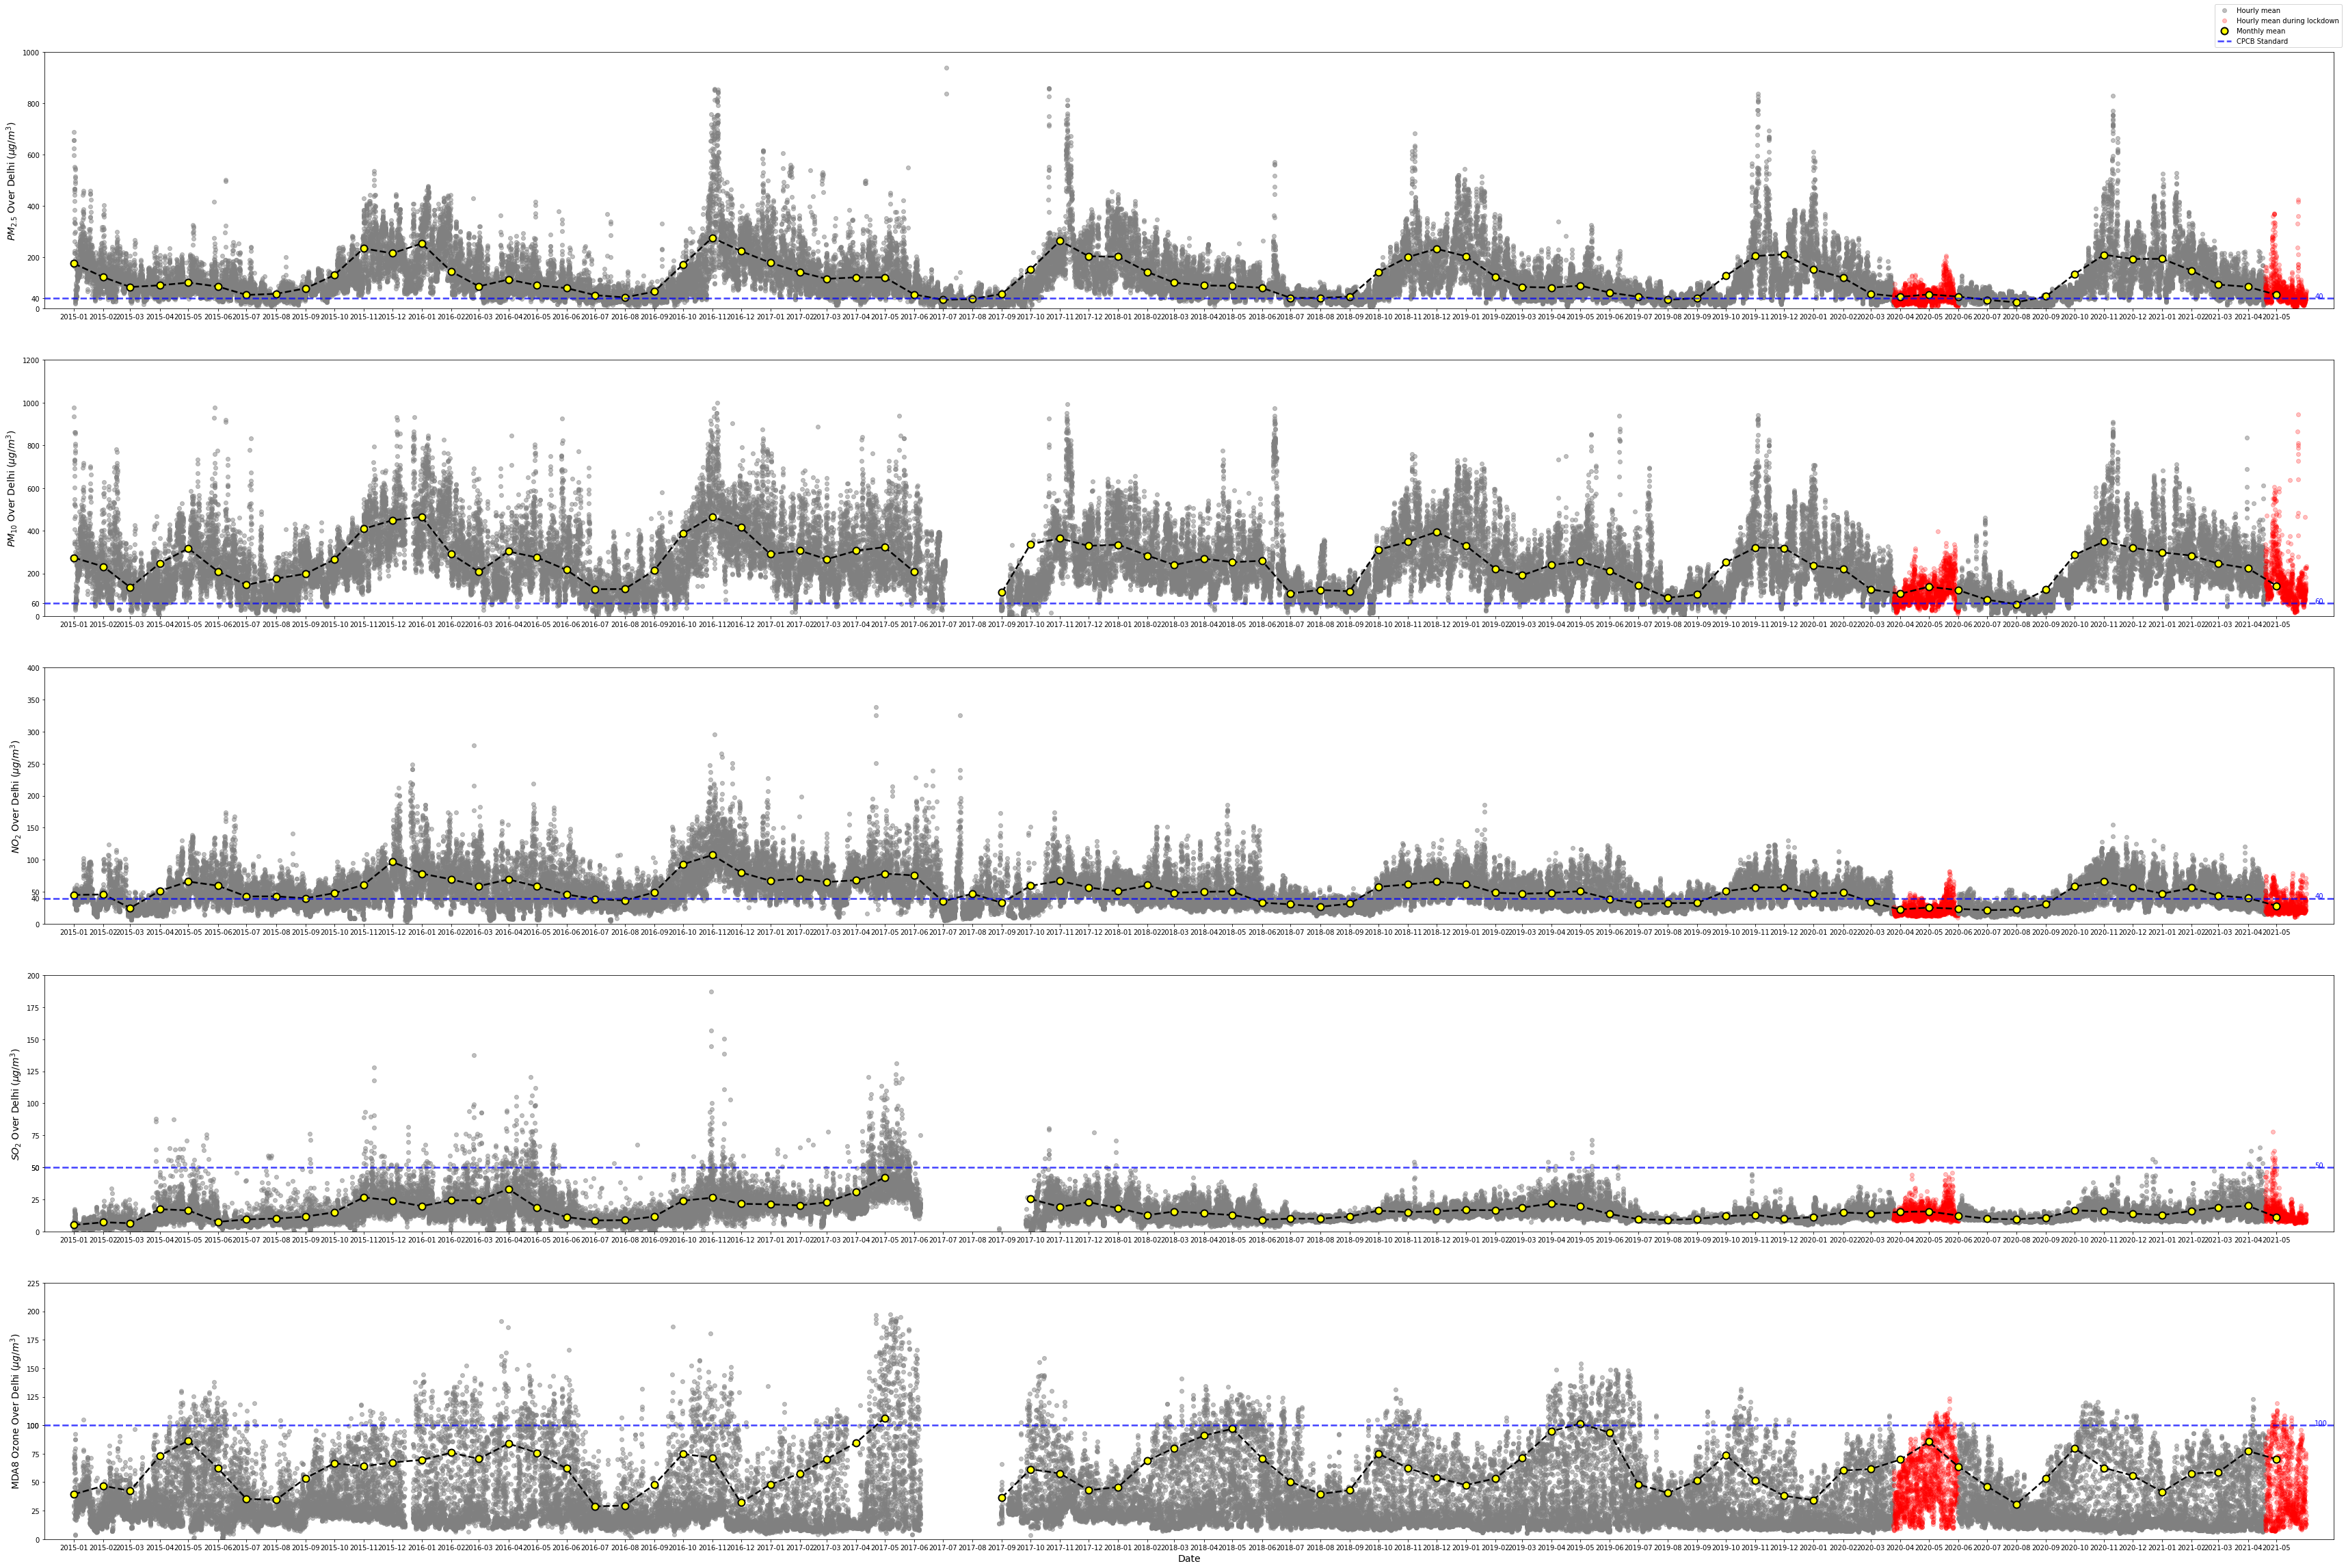

In [85]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}

fig, axs = plt.subplots(5, figsize=(60, 40))

for pollutant, ax in zip(pollutants, axs):
    dat = holistic['hourly'][pollutant]['mean'].loc[:'2021-05-31'] # df with hourly mean values
    y1  = dat.loc['2015-01-01':'2020-03-24']
    ld1 = dat.loc['2020-03-25':'2020-05-31']
    y2  = dat.loc['2020-06-01':'2021-04-18']
    ld2 = dat.loc['2021-04-19':'2021-05-31']
    mm  = holistic['monthly'][pollutant]['mean'].loc['2015-01-31':'2021-05-31'] # df with monthly means
    indices = [pd.to_datetime(str(date)[0:8] + '01') for date in mm.index]
    mm.index = indices
    
    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, \
            label='Hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, \
            label='Hourly mean during lockdown')
    ax.plot(y2, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5)
    ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25)

    # Overlaying hourly mean values with monthly means
    ax.plot(mm, linestyle='--', color = 'black', linewidth=2.5) # monthly means as dotted lines
    ax.plot(mm, marker='o', markersize=10, linewidth=0,
            markerfacecolor='yellow',
            markeredgecolor='black',
            markeredgewidth=2, label='Monthly mean') # monthly means as yellow dot
        
    ax.hlines(y=standards[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1]-20, 
              color='blue', linestyles='dashed', linewidth=2.5, label='CPCB Standard', 
              zorder=10, alpha=0.75)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_yticks(list(ax.get_yticks()) + [standards[pollutant]])
    ax.set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=14)
    
    xticks = [(str(date)[0:7]) for date in mm.index]
    ax.set_xticks(mm.index)
    ax.set_xticklabels(xticks)
    ax.set_xlim(pd.to_datetime('2014-12-01'), pd.to_datetime('2021-06-30'))
    ax.text(x=ax.get_xticks()[-1]+40, y=standards[pollutant], 
            s=standards[pollutant], color='blue')
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.005, 1.20), loc='upper right')
    
plt.xlabel('Date', fontsize=14)
fig_title = 'Timeseries_2020-21.tiff'
plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Visualize hourly and weekly means during 2020 lockdown

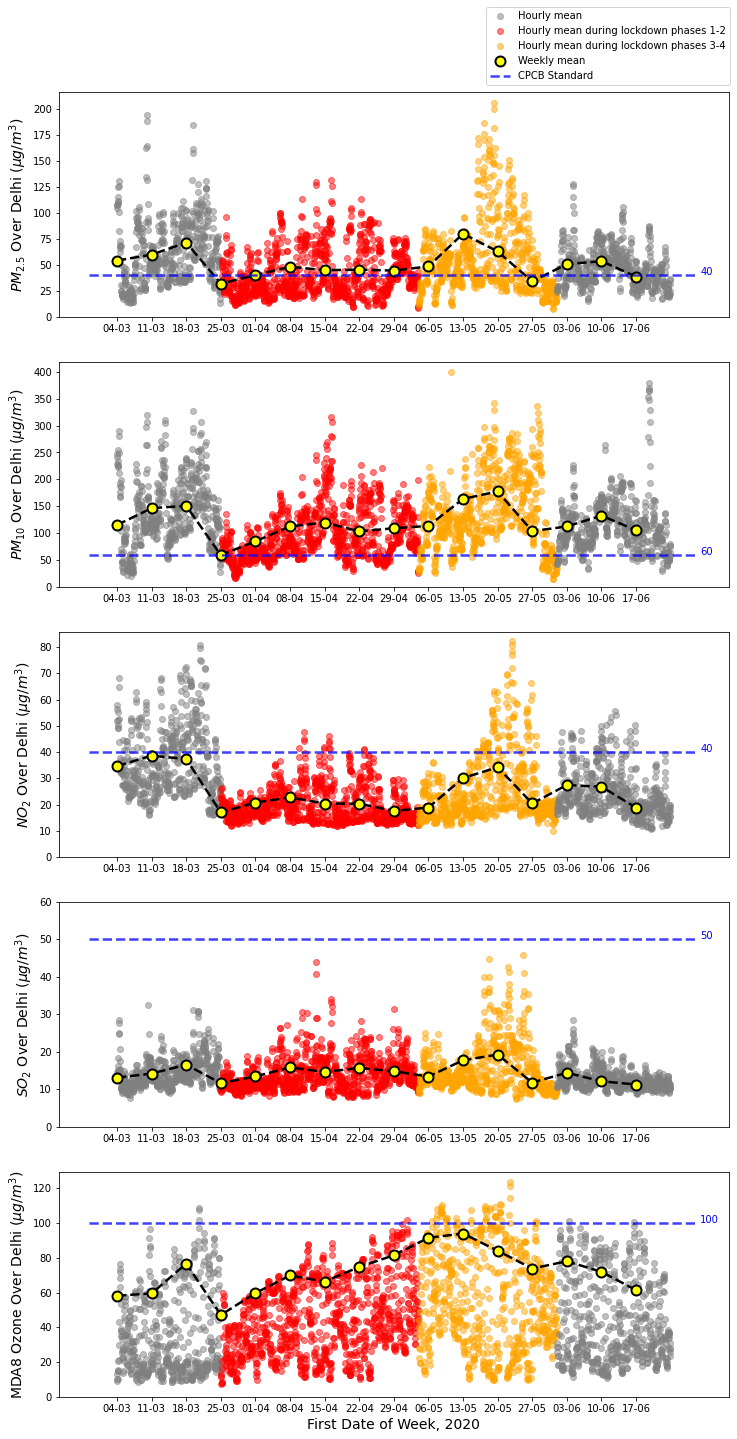

In [78]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}
standards = {'PM2.5':40, 'PM10':60, 'SO2':50, 'NO2':40, 'Ozone':100}

fig, axs = plt.subplots(5, figsize=(12, 24))

for pollutant, ax in zip(pollutants, axs):
    dat = holistic['hourly'][pollutant]['mean'].loc[:'2021-05-31'] # df with hourly mean values
    y1  = dat.loc['2020-03-04':'2020-03-24']
    ld1 = dat.loc['2020-03-25':'2020-05-03']
    ld2 = dat.loc['2020-05-04':'2020-05-31']
    y2  = dat.loc['2020-06-01':'2020-06-23']
    dm = holistic['daily'][pollutant]['mean'].loc['2020-03-04':'2020-06-23'] # df with daily means
    wm = dm.resample('7D').mean()
    
    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, \
            label='Hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.5, \
            label='Hourly mean during lockdown phases 1-2')
    ax.plot(ld2, linestyle='', marker='o', color='orange', mec='orange', alpha=0.5, \
            label='Hourly mean during lockdown phases 3-4')
    ax.plot(y2, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5)

    # Overlaying hourly mean values with weekly means
    ax.plot(wm, linestyle='--', color = 'black', linewidth='2.5') # weekly means as dotted lines
    ax.plot(wm, marker='o', markersize=10, linewidth=0,
            markerfacecolor='yellow',
            markeredgecolor='black',
            markeredgewidth=2, label='Weekly mean') # weekly means as yellow dot
    
    if pollutant == 'SO2':
        ax.set_ylim(0, 60)
    else:
        ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=14)
    dates = wm.index
    ax.set_xticks(dates)
    ax.set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
    ax.hlines(y=standards[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
              color='blue', linestyles='dashed', linewidth=2.5, label='CPCB Standard', 
              zorder=10, alpha=0.75)
    ax.text(x=ax.get_xticks()[-1]+13, y=standards[pollutant], 
            s=standards[pollutant], color='blue')
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.01, 1.4), loc='upper right')
    
plt.xlabel('First Date of Week, 2020', fontsize=14)
fig_title = 'Lockdown_Means_2020.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Visualize hourly and weekly means during 2021 lockdown

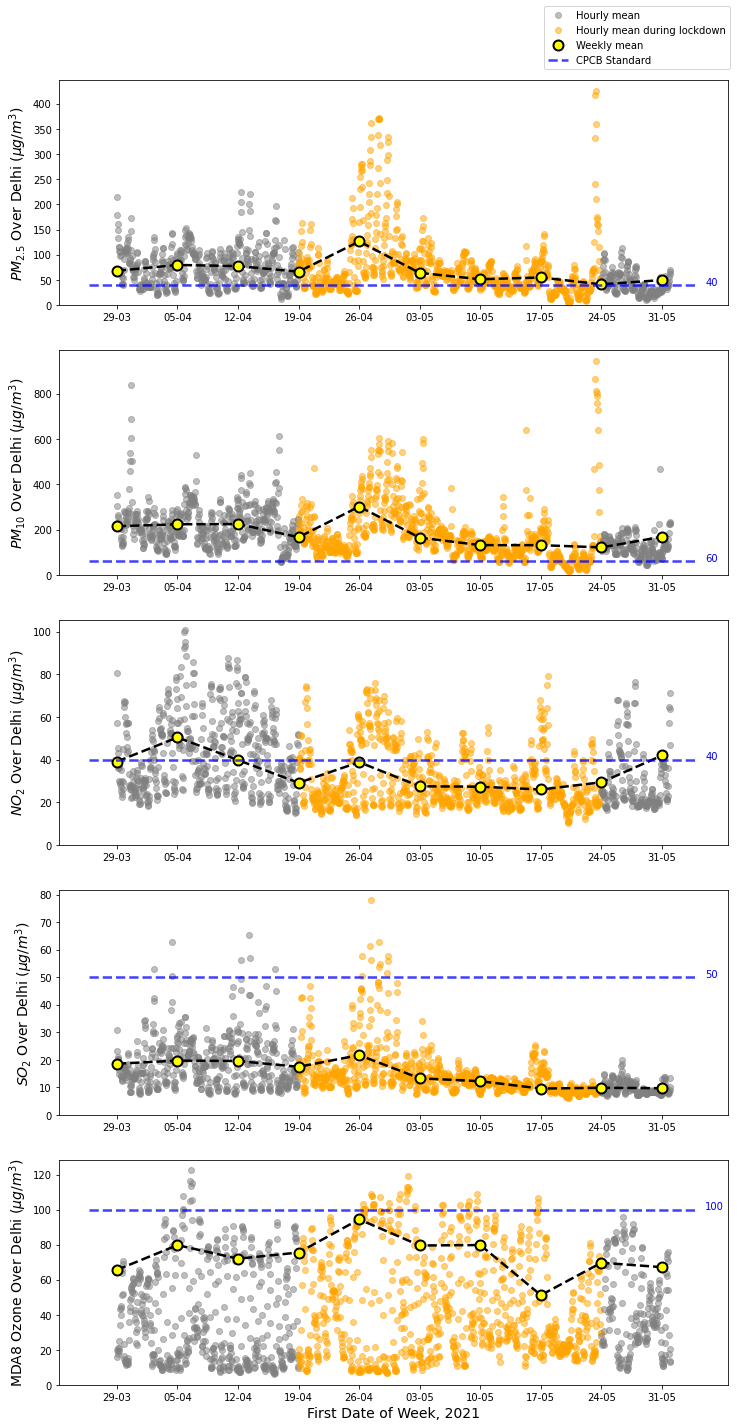

In [79]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

fig, axs = plt.subplots(5, figsize=(12, 24))

for pollutant, ax in zip(pollutants, axs):
    dat = holistic['hourly'][pollutant]['mean'].loc[:'2021-05-31'] # df with hourly mean values
    y1  = dat.loc['2021-03-29':'2021-04-18']
    ld = dat.loc['2021-04-19':'2021-05-23']
    y2 = dat.loc['2021-05-24':'2021-05-31']
    dm = holistic['daily'][pollutant]['mean'].loc['2021-03-29':'2021-05-31'] # df with daily means
    wm = dm.resample('7D').mean()
    
    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, \
            label='Hourly mean')
    ax.plot(ld, linestyle='', marker='o', color='orange', mec='orange', alpha=0.5, \
            label='Hourly mean during lockdown')
    ax.plot(y2, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5)

    # Overlaying hourly mean values with weekly means
    ax.plot(wm, linestyle='--', color = 'black', linewidth='2.5') # weekly means as dotted lines
    ax.plot(wm, marker='o', markersize=10, linewidth=0,
            markerfacecolor='yellow',
            markeredgecolor='black',
            markeredgewidth=2, label='Weekly mean') # weekly means as yellow dot
    
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=14)
    dates = wm.index
    ax.set_xticks(dates)
    ax.set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
    ax.hlines(y=standards[pollutant], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], 
              color='blue', linestyles='dashed', linewidth=2.5, label='CPCB Standard', 
              zorder=10, alpha=0.75)
    ax.text(x=ax.get_xticks()[-1]+5, y=standards[pollutant], 
            s=standards[pollutant], color='blue')
    
    if pollutant == 'PM2.5':
        ax.legend(bbox_to_anchor=(1.01, 1.35), loc='upper right')
    
plt.xlabel('First Date of Week, 2021', fontsize=14)
fig_title = 'Lockdown_Means_2021.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Line plots of weekly pollutant averages during 2020 and 2021 lockdowns

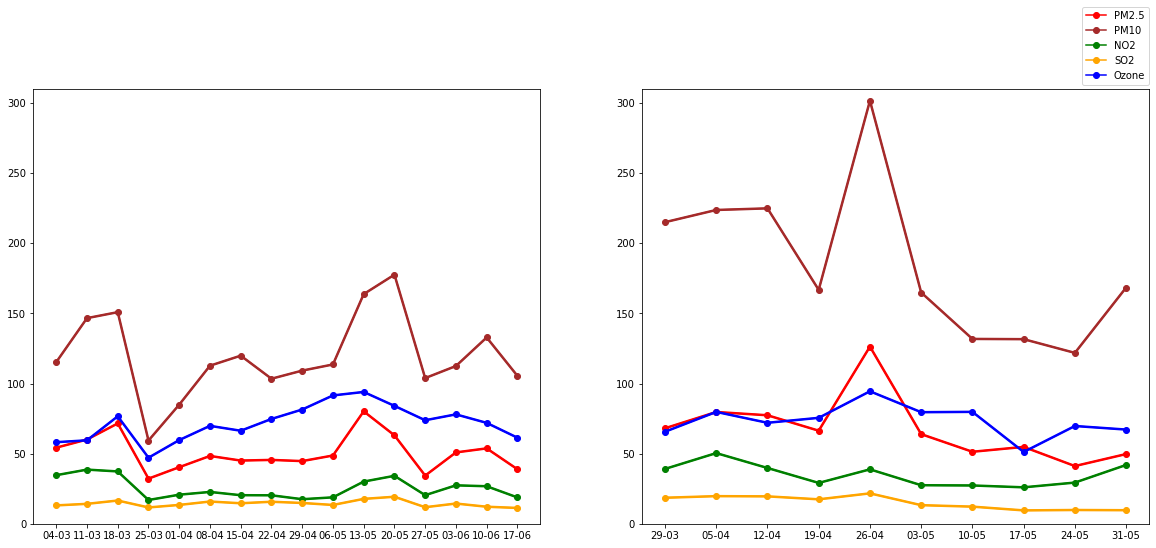

In [56]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
colors = ['red', 'brown', 'green', 'orange', 'blue']

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

for pollutant, color in zip(pollutants, colors):
    dm = holistic['daily'][pollutant].loc['2020-03-04':'2020-06-23'] # df with daily means
    wm = dm.resample('7D').mean()
    axs[0].plot(wm['mean'], marker='o', color=color, label=pollutant)
    axs[0].plot(wm['mean'], color=color, linewidth='2.5')
    # axs[0].fill_between(wm.index, wm['minimum'], wm['maximum'], facecolor=color, alpha=0.25)
    
    dates = wm.index
    axs[0].set_xticks(dates)
    axs[0].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
    dm = holistic['daily'][pollutant]['mean'].loc['2021-03-29':] # df with daily means
    wm = dm.resample('7D').mean()
    axs[1].plot(wm, marker='o', color=color, label=pollutant)
    axs[1].plot(wm, color=color, linewidth='2.5')

    dates = wm.index
    axs[1].set_xticks(dates)
    axs[1].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
axs[0].set_ylim(0, 310)
axs[1].set_ylim(0, 310)
plt.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
plt.show()

## Line plots of weekly averages, overlaid with minimum and maximum values

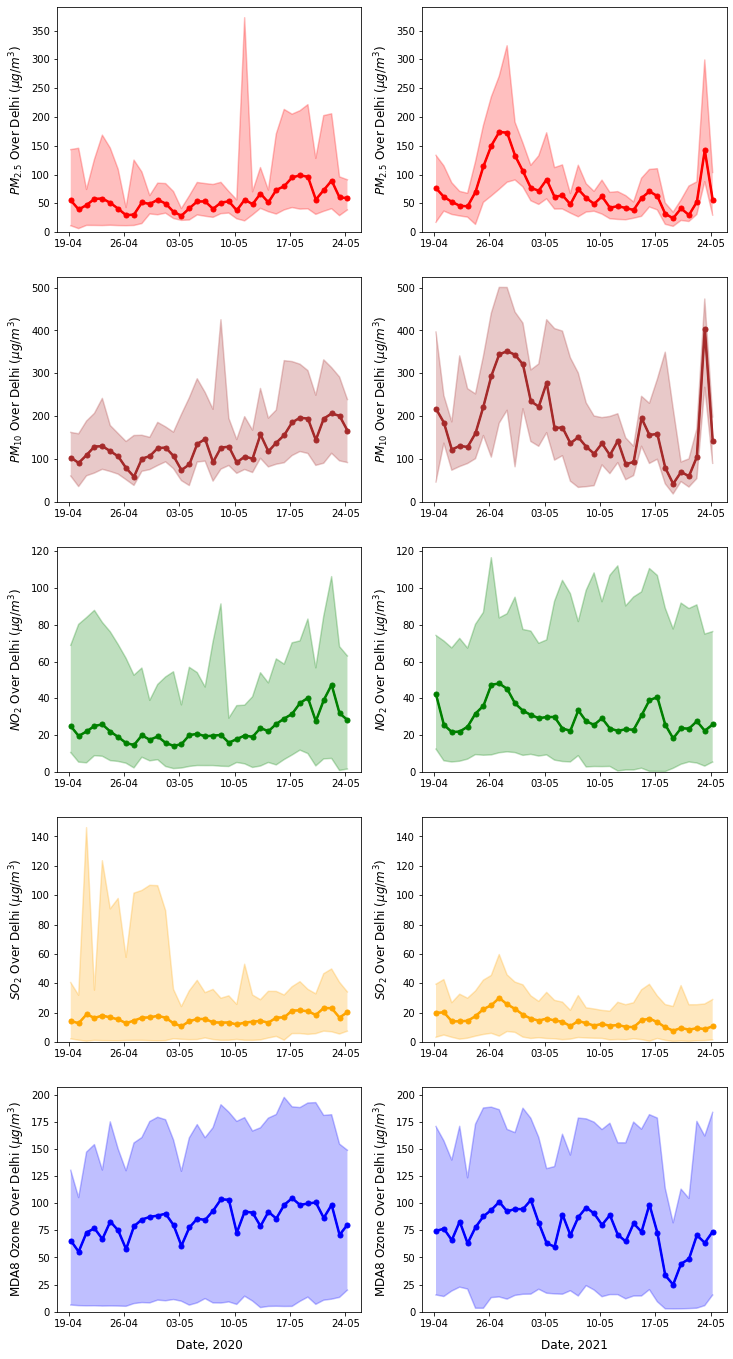

In [84]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
colors = ['red', 'brown', 'green', 'orange', 'blue']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

fig, axs = plt.subplots(5, 2, figsize=(12, 24))

for pollutant, color, pair_ax in zip(pollutants, colors, axs):
    dm = holistic['daily'][pollutant].loc['2020-04-19':'2020-05-24'] # df with daily means
    wm = dm.resample('7D').mean()
    pair_ax[0].plot(dm['mean'], marker='o', markersize=5, color=color, label=pollutant)
    pair_ax[0].plot(dm['mean'], color=color, linewidth='2.5')
    pair_ax[0].plot(dm['minimum'], color=color, alpha=0.25)
    pair_ax[0].plot(dm['maximum'], color=color, alpha=0.25)
    pair_ax[0].fill_between(dm.index, dm['minimum'], dm['maximum'], facecolor=color, alpha=0.25)
    pair_ax[0].set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=12)
    
    dates = wm.index
    pair_ax[0].set_xticks(dates)
    pair_ax[0].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
    dm = holistic['daily'][pollutant].loc['2021-04-19':'2021-05-24'] # df with daily means
    wm = dm.resample('7D').mean()
    pair_ax[1].plot(dm['mean'], marker='o', markersize=5, color=color, label=pollutant)
    pair_ax[1].plot(dm['mean'], color=color, linewidth='2.5')
    pair_ax[1].plot(dm['minimum'], color=color, alpha=0.25)
    pair_ax[1].plot(dm['maximum'], color=color, alpha=0.25)
    pair_ax[1].fill_between(dm.index, dm['minimum'], dm['maximum'], facecolor=color, alpha=0.25)
    pair_ax[1].set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=12)
    
    dates = wm.index
    pair_ax[1].set_xticks(dates)
    pair_ax[1].set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
    
    top = max([pair_ax[0].get_ylim()[1], pair_ax[1].get_ylim()[1]])
    
    pair_ax[0].set_ylim(0, top)
    pair_ax[1].set_ylim(0, top)
    
    if pollutant == 'Ozone':
        pair_ax[0].set_xlabel('Date, 2020', fontsize=12, labelpad=10)
        pair_ax[1].set_xlabel('Date, 2021', fontsize=12, labelpad=10)
    
# plt.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
fig_title = 'LinePlots_DailyMeans_2020_2021.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Line plots of weekly averages during shared lockdown dates for years 2015-2019, overlaid with upper and lower standard error

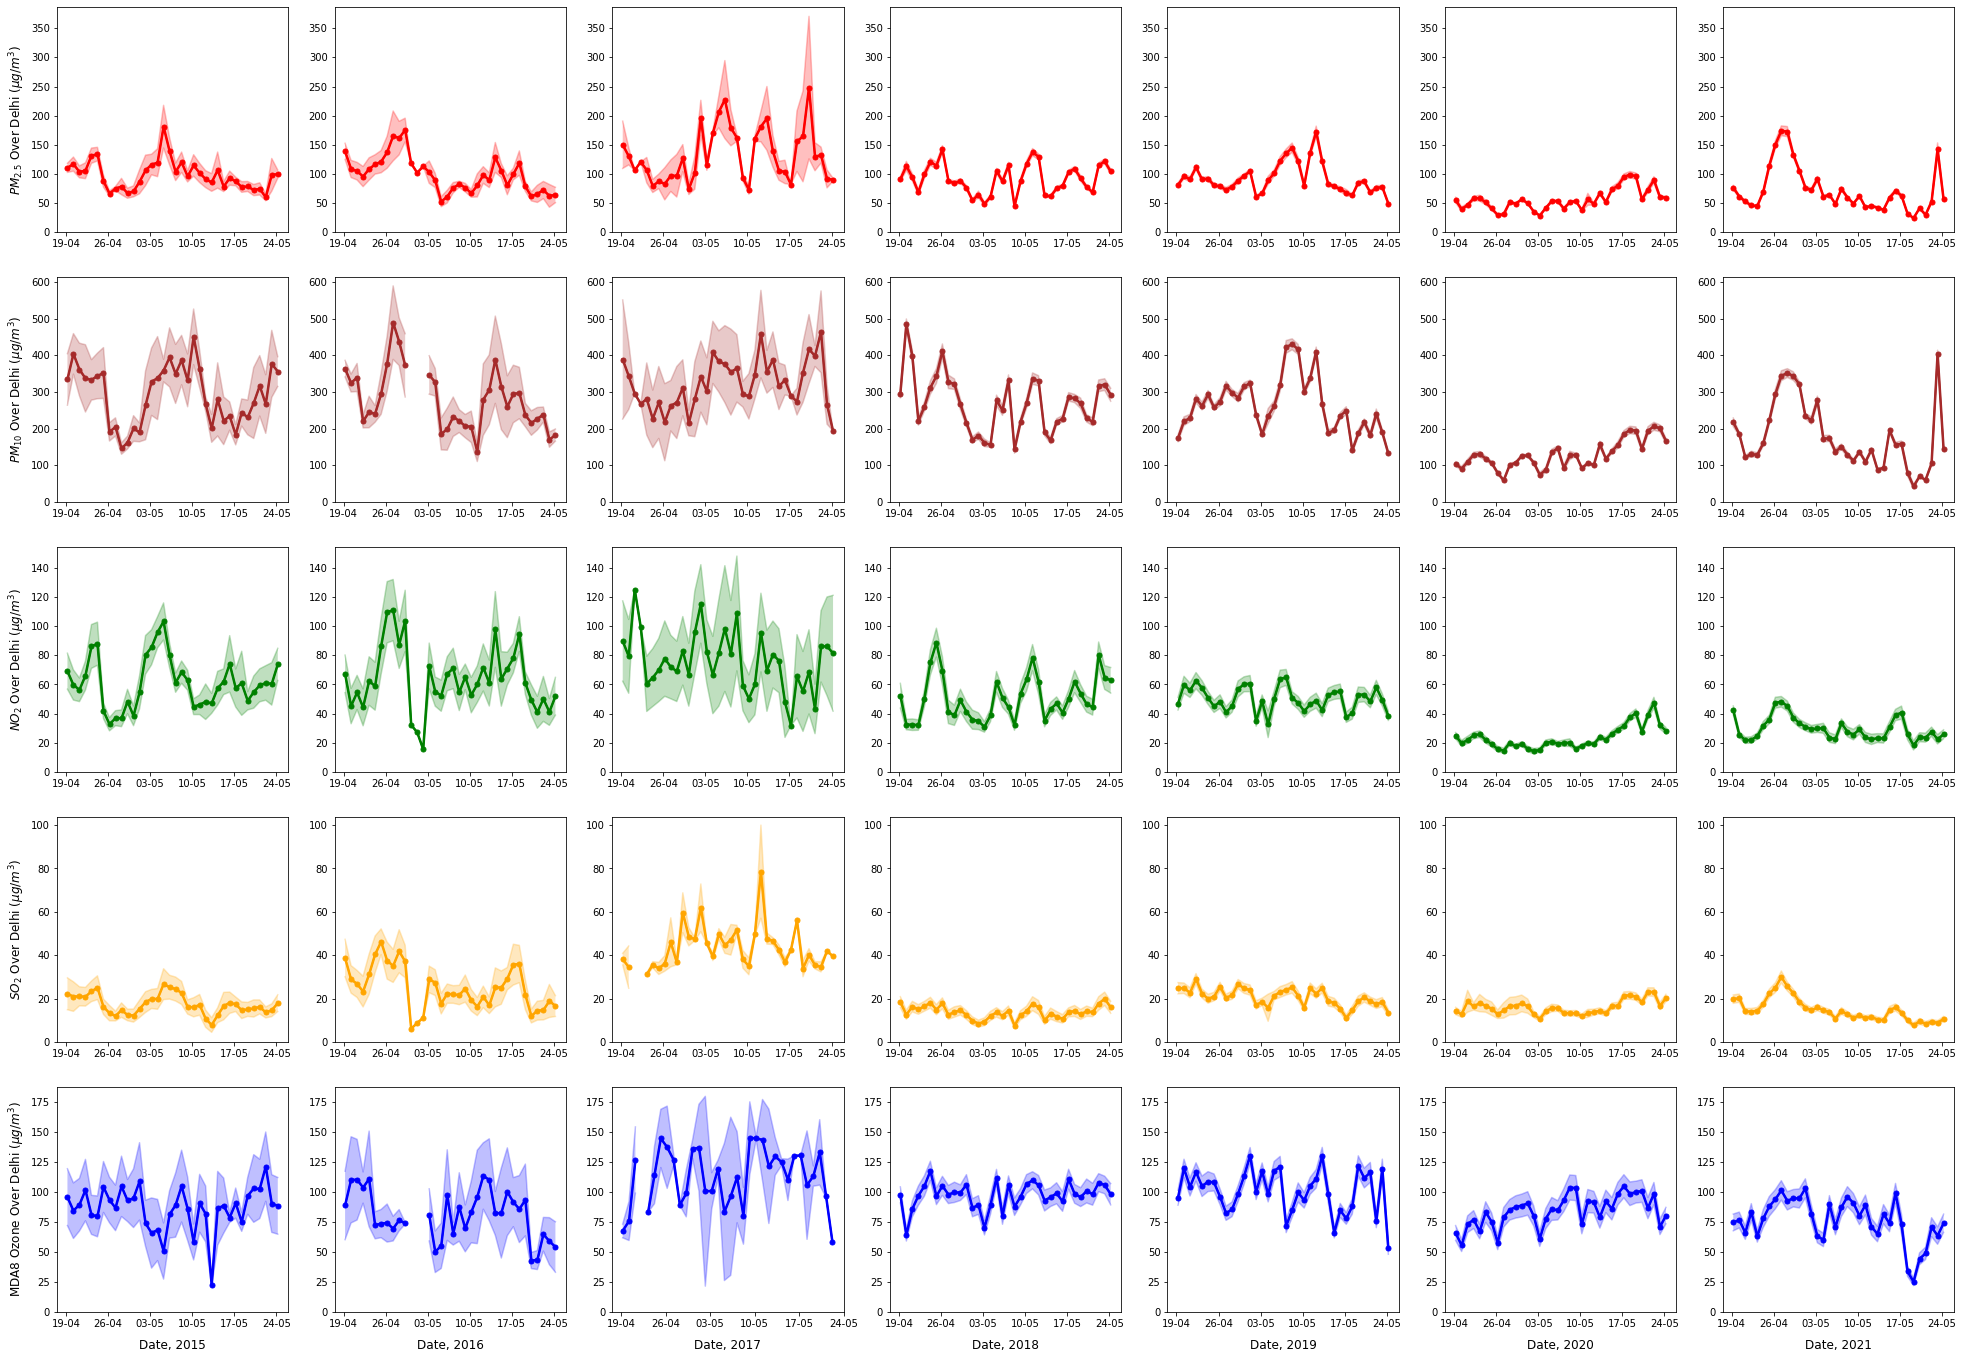

In [18]:
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
colors = ['red', 'brown', 'green', 'orange', 'blue']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}

avgs = defaultdict(list)
fig, all_axs = plt.subplots(5, 7, figsize=(34, 24))

for pollutant, color, axs in zip(pollutants, colors, all_axs):
    
    years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
    
    for ax, year in zip(axs, years):
        dm = holistic['daily'][pollutant].loc[year+'-04-19':year+'-05-24'] # df with daily means
        wm = dm.resample('7D').mean()
        ax.plot(dm['mean'], marker='o', markersize=5, color=color, label=pollutant)
        ax.plot(dm['mean'], color=color, linewidth='2.5')
        ax.plot(dm['lowermean'], color=color, alpha=0.25)
        ax.plot(dm['uppermean'], color=color, alpha=0.25)
        ax.fill_between(dm.index, dm['lowermean'], dm['uppermean'], facecolor=color, alpha=0.25)

        dates = wm.index
        ax.set_xticks(dates)
        ax.set_xticklabels([str(d)[8:10] + str(d)[7:8] + str(d)[5:7] for d in dates])
        
        avg = dm['mean'].mean()
        avgs[pollutant].append(avg)
        
        if year == '2015':
            ax.set_ylabel(pol_labels_dict[pollutant] + ' Over Delhi ($µg/m^3$)', fontsize=12)
    
    top = max([axs[i].get_ylim()[1] for i in range(7)])
    for ax in axs:
        ax.set_ylim(0, top)
    
    if pollutant == 'Ozone':
        for ax, year in zip(axs, years):
            ax.set_xlabel('Date, ' + year, fontsize=12, labelpad=10)
    
# plt.legend(bbox_to_anchor=(1.01, 1.20), loc='upper right')
fig_title = 'LinePlots_DailyMeanswithSE_2020_2021.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Yearly averages of daily values during shared lockdown dates

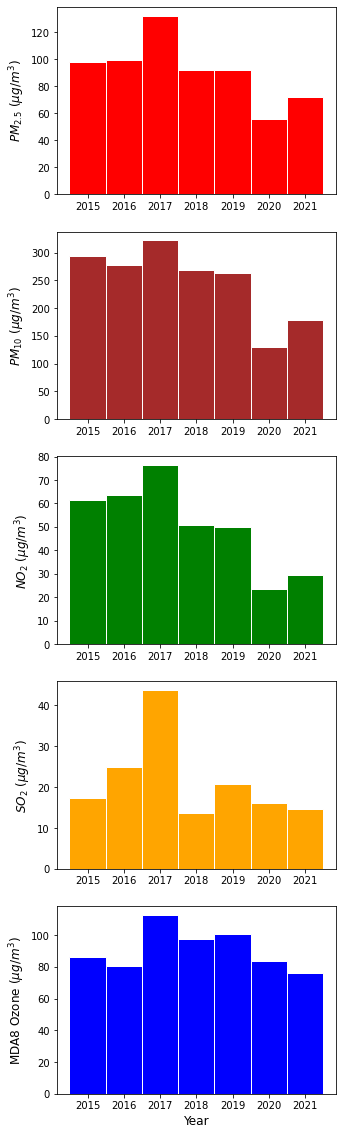

In [129]:
colors = ['red', 'brown', 'green', 'orange', 'blue']
pol_labels_dict = {'PM2.5': '$PM_{2.5}$', 'PM10': '$PM_{10}$', 'NO2': '$NO_2$', 
                   'SO2': '$SO_2$', 'Ozone': 'MDA8 Ozone'}
fig, axs = plt.subplots(5, 1, figsize=(5, 20))

for pollutant, ax, color in zip(list(avgs.keys()), axs, colors):
    ax.bar(x=list(range(7)), height=avgs[pollutant], width=1, color=color, edgecolor='white')
    ax.set_xticks(list(range(7)))
    ax.set_xticklabels(list(range(2015, 2022)))
    ax.set_ylabel(pol_labels_dict[pollutant] + ' ($µg/m^3$)', fontsize=12)
    if pollutant == 'Ozone':
        ax.set_xlabel('Year', fontsize=12)
    
fig_title = 'Avgs_During_Shared_LD_Dates_2015-2021.tiff'
# plt.savefig(fig_title, bbox_inches="tight")   
plt.show()

## Observing individual stations

102


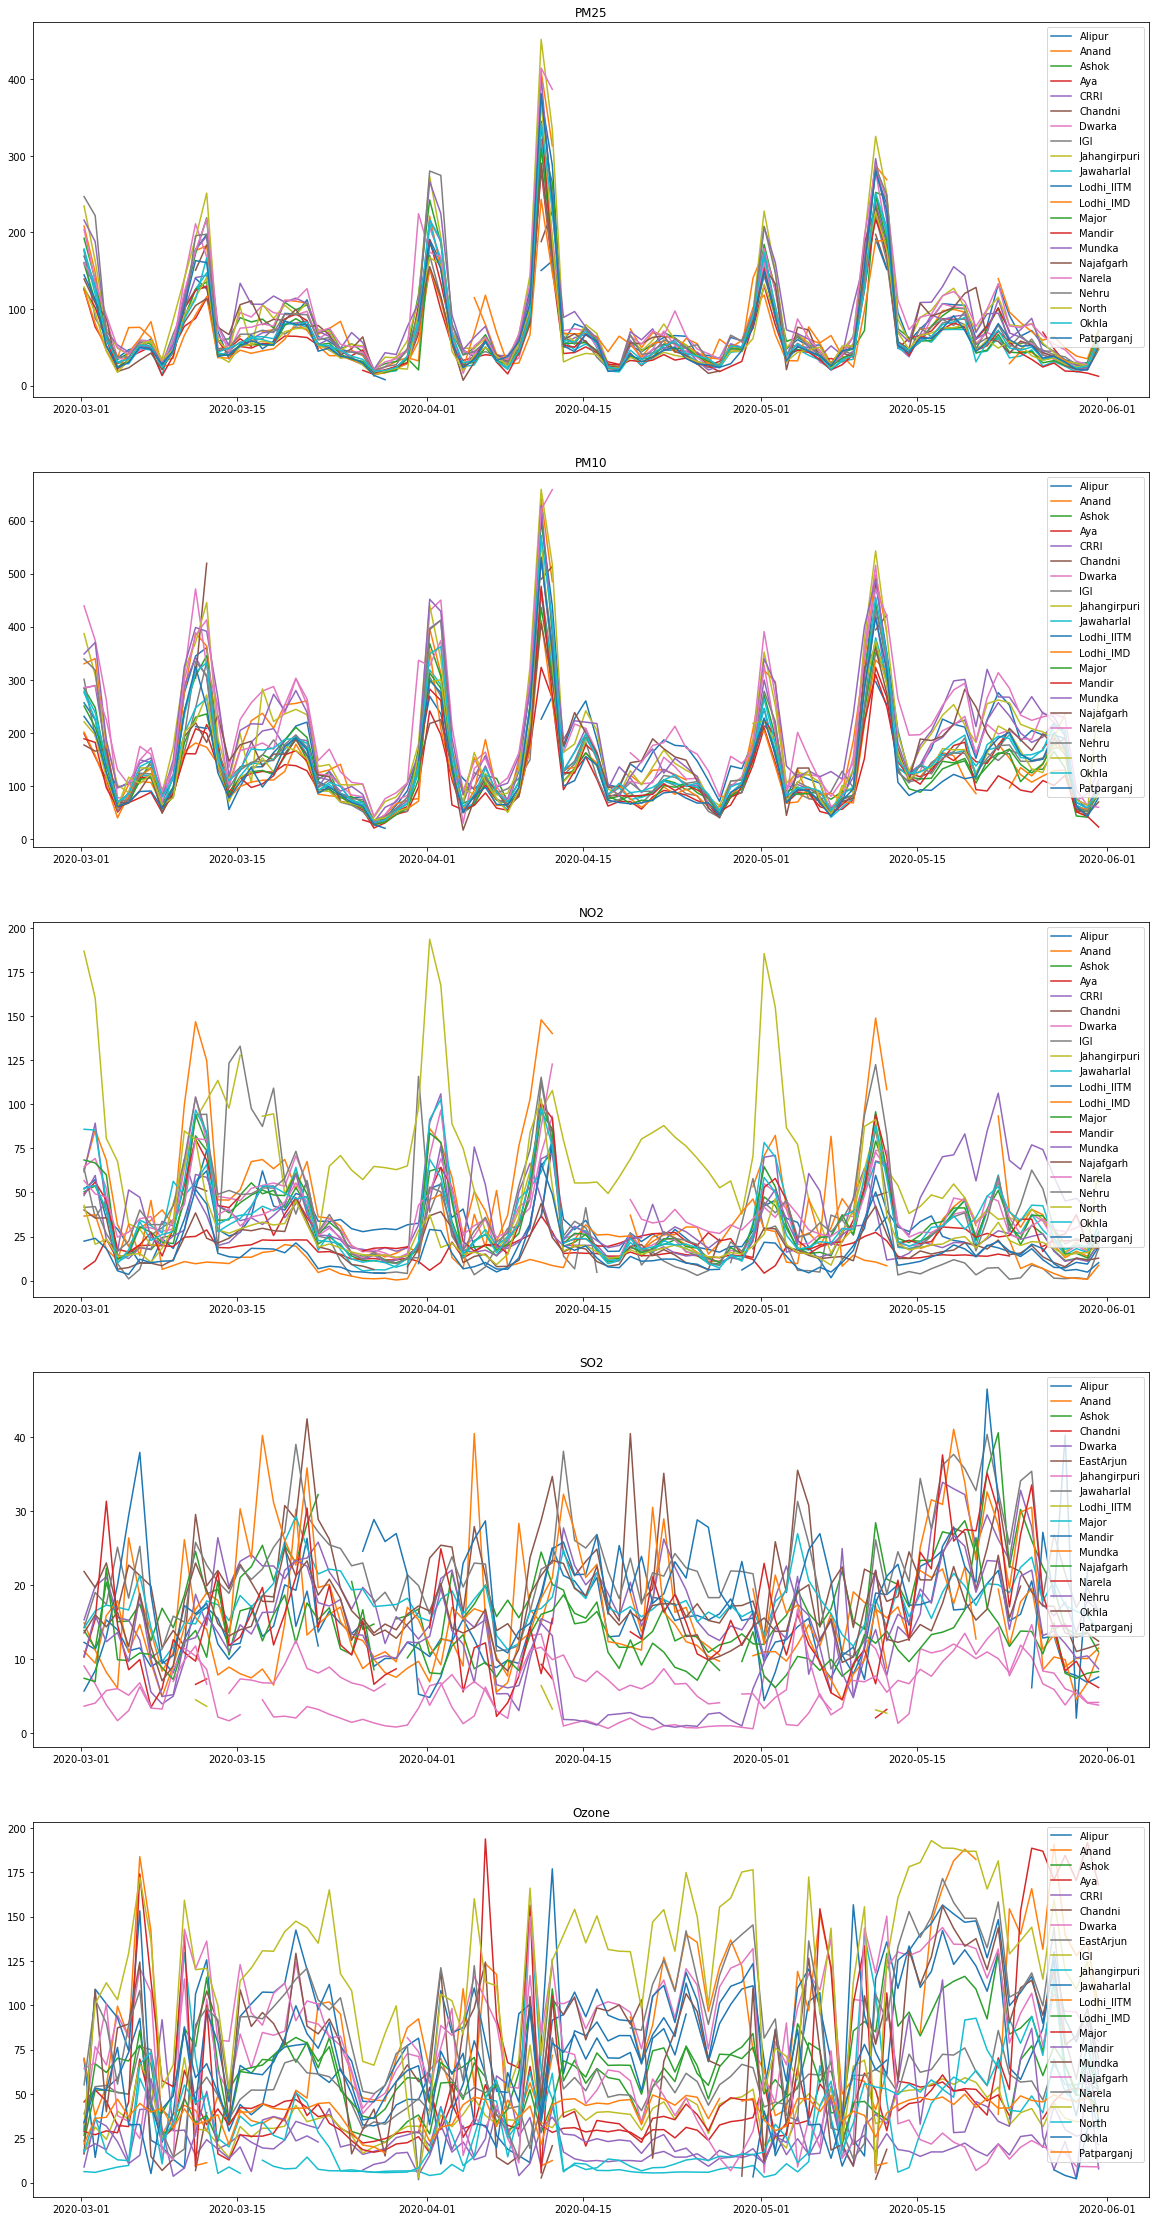

In [100]:
fig, axs = plt.subplots(5, figsize=(20, 40))
count = 0
ahead = list(station_data.keys())[:30]
skip = ['ITO', 'IHBAS', 'Punjabi', 'Pusa_DPCC', 'NSIT', 'Bawana', 'Karni', 'DTU']
species = ['PM25', 'PM10', 'NO2', 'SO2', 'Ozone']
for station in station_data:
    for ax, pollutant in zip(axs, species):
        if not station in ahead:
            continue
        if station in skip:
            continue
        if pollutant in station_data[station]['daily'].columns:
            ax.plot(station_data[station]['daily'][pollutant].loc['2020-03':'2020-05'], label=station)
            count += 1
        ax.legend()
        ax.set_title(pollutant)
print(count)